# Code & Experiment Component

<h2> Name: Syed Husain Mustafa</h2>
<h2> Matriculation Number: 03737449 </h2>
<h2> Gloss ID: tum_ldsi_28 <h2>

[View Results of trained classifers](#Results)

In [1]:
import spacy
import json
import random
import collections
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
corpus_fpath = 'ldsi_w21_curated_annotations_v2.json'
data = json.load(open(corpus_fpath))

In [3]:
data.keys()

dict_keys(['documents', 'annotations', 'types'])

In [554]:
data['documents'][0].keys()

dict_keys(['_id', 'name', 'plainText', 'outcome'])

In [555]:
data['annotations'][0].keys()

dict_keys(['_id', 'start', 'end', 'document', 'type'])

In [553]:
data['types'][0].keys()

dict_keys(['_id', 'name', 'isA', 'attributes'])

In [5]:
len(data['annotations'])

15349

In [549]:
len(data['documents'])

540

In [7]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}
doc_name_by_outcome = {d['name']: d['outcome'] for d in data['documents']}

In [8]:
len(data['documents'])

540

In [9]:
data['documents'][0].keys()

dict_keys(['_id', 'name', 'plainText', 'outcome'])

In [10]:
data['annotations'][0].keys()

dict_keys(['_id', 'start', 'end', 'document', 'type'])

In [11]:
data['annotations'][0]['document']

'61aea57397ad59b4cfc41399'

## Phase 1: Data Splitting

### Identifying Annotated Documents

In [12]:
annotated_documents = list()
for i in range(len(annotations)):
    if annotations[i]['document'] in documents_by_id.keys():
        index = annotations[i]['document']
        if documents_by_id[index] not in annotated_documents:
            annotated_documents.append(documents_by_id[index])

In [13]:
annotated_documents[0].keys()

dict_keys(['_id', 'name', 'plainText', 'outcome'])

In [14]:
print("Number of annotated documents are ",len(annotated_documents))

Number of annotated documents are  141


In [15]:
annotated_documents[0].keys()

dict_keys(['_id', 'name', 'plainText', 'outcome'])

In [16]:
annotated_documents[0]['_id']

'61aea57397ad59b4cfc41399'

In [17]:
test_documents = list()
counter_granted = 1
counter_denied = 1
for i in range(len(annotated_documents)):
    if annotated_documents[i]['outcome'] == 'denied' and counter_denied <= 7:
        test_documents.append(annotated_documents[i])
        counter_denied += 1
    elif annotated_documents[i]['outcome'] == 'granted' and counter_granted <= 7:
        test_documents.append(annotated_documents[i])
        counter_granted += 1
    

In [18]:
len(test_documents)

14

In [20]:
train_documents = list()
flag = 0
for i in range(len(annotated_documents)):
    flag = 0
    for j in range(len(test_documents)):
        if annotated_documents[i]['_id'] == test_documents[j]['_id']:
            flag = 1
    if flag == 0:
        train_documents.append(annotated_documents[i])

In [21]:
dev_documents = list()
counter_granted = 1
counter_denied = 1
for i in range(len(train_documents)):
    if train_documents[i]['outcome'] == 'denied' and counter_denied <= 7:
        dev_documents.append(train_documents[i])
        counter_denied += 1
    elif train_documents[i]['outcome'] == 'granted' and counter_granted <= 7:
        dev_documents.append(train_documents[i])
        counter_granted +=1

In [22]:
train_documents = list()
for i in range(len(annotated_documents)):
    flag = 0
    for j in range(len(test_documents)):
        if annotated_documents[i]['_id'] == test_documents[j]['_id']:
            flag = 1
    for j in range(len(dev_documents)):
        if annotated_documents[i]['_id'] == dev_documents[j]['_id']:
            flag = 1
    if flag == 0:
        train_documents.append(annotated_documents[i])

In [23]:
len(train_documents)

113

In [24]:
dev_ids = list()
for doc in dev_documents:
    dev_ids.append(doc['_id'])

In [25]:
test_ids = list()
for doc in test_documents:
    test_ids.append(doc['_id'])

### Listing Test and Dev Set IDs

In [479]:
print("Test Case IDs")
test_document_ids = list()
for i in range(len(test_ids)):
    print(test_ids[i])
    test_document_ids.append(test_ids[i])

Test Case IDs
61aea57397ad59b4cfc41399
61aea55d97ad59b4cfc412be
61aea56f97ad59b4cfc4134b
61aea55c97ad59b4cfc41297
61aea57197ad59b4cfc41377
61aea55e97ad59b4cfc412d8
61aea57397ad59b4cfc4138e
61aea55c97ad59b4cfc412ae
61aea55e97ad59b4cfc412d4
61aea57497ad59b4cfc413c4
61aea57497ad59b4cfc413b6
61aea55c97ad59b4cfc412a0
61aea57197ad59b4cfc4136e
61aea55f97ad59b4cfc41334


In [480]:
print("Dev Case IDs")
dev_document_ids = list()
for i in range(len(dev_ids)):
    print(dev_ids[i])
    dev_document_ids.append(dev_ids[i])

Dev Case IDs
61aea57097ad59b4cfc4135a
61aea55d97ad59b4cfc412bf
61aea55e97ad59b4cfc412ee
61aea56f97ad59b4cfc41343
61aea55c97ad59b4cfc4129d
61aea55c97ad59b4cfc4129f
61aea57397ad59b4cfc4139e
61aea57197ad59b4cfc4136b
61aea55d97ad59b4cfc412c1
61aea57497ad59b4cfc413ba
61aea57497ad59b4cfc413cc
61aea57297ad59b4cfc41381
61aea55e97ad59b4cfc412df
61aea55c97ad59b4cfc4129e


## Phase 2: Deciding a Sentence Segmenter

### 2.1 Standard Segmentation Analysis

In [28]:
# Using SpaCy sentence segmenter
nlp = spacy.load("en_core_web_sm")

In [29]:
spacy_sentence_count = 0
spacy_annotations = list()
for d in train_documents:
    spacy_annotations_doc = list()
    spacy_sentence_count = spacy_sentence_count + len(list(nlp(d['plainText']).sents))
    for sent in nlp(d['plainText']).sents:
        spacy_annotations_doc.append({'start': sent.start_char, 'end' : sent.end_char})
    spacy_annotations.append({'_id': d['_id'], 'indices': spacy_annotations_doc})

In [30]:
print('Number of sentences detected by SpaCy in entire Train-Set', spacy_sentence_count)

Number of sentences detected by SpaCy in entire Train-Set 12859


<center><b> Error Analysis of Steps 2.1, 2.2, & 2.3 are given at the end of phase 2. Followed by examination of 3 sentences per each segmenter model. </b></center>

### 2.2 Improved Segmentation Analysis

In [31]:
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('Fed. Reg.', [{ORTH:'Fed. Reg.'}])
nlp.tokenizer.add_special_case('Supp. ', [{ORTH: 'Supp. '}])
nlp.tokenizer.add_special_case('St. Petersburg', [{ORTH: 'St. Petersburg'}])

In [32]:
improved_spacy_sentence_count = 0
improved_spacy_annotations = list()
for d in train_documents:
    improved_spacy_annotations_doc = list()
    improved_spacy_sentence_count = improved_spacy_sentence_count + len(list(nlp(d['plainText']).sents))
    for sent in nlp(d['plainText']).sents:
        improved_spacy_annotations_doc.append({'start': sent.start_char, 'end' : sent.end_char})
    improved_spacy_annotations.append({'_id': d['_id'], 'indices': improved_spacy_annotations_doc})

In [35]:
print("Number of sentences detected by Improved SpaCy in entire Train-Set", improved_spacy_sentence_count)

Number of sentences detected by Improved SpaCy in entire Train-Set 11806


### 2.3 Law Specific Sentence Segmenter
https://github.com/jsavelka/luima_sbd

In [36]:
from luima_sbd import sbd_utils
from luima_sbd.sbd_utils import text2sentences

In [37]:
text = text2sentences(data['documents'][0]['plainText'], offsets=False)

In [43]:
luima_sentence_count = 0
    
for d in train_documents:
    luima_sentence_count = spacy_sentence_count + len(text2sentences(d['plainText'], offsets=False))

In [44]:
print("umber of sentences detected by Luima in entire Train-Set", luima_sentence_count)

umber of sentences detected by Luima in entire Train-Set 12992


In [45]:
indices=text2sentences(train_documents[0]['plainText'], offsets=True)

In [46]:
# Retrieving annotation indices predicted by luima-package
luima_annotations = list()
for d in train_documents:
    luima_annotations_doc = list()
    indices = text2sentences(d['plainText'], offsets=True)
    for index in indices:
        luima_annotations_doc.append({'start': index[0], 'end' : index[1]})
    luima_annotations.append({'_id': d['_id'], 'indices': luima_annotations_doc})

In [561]:
luima_annotations[0]['_id'][0]

'6'

In [51]:
luima_annotations[0].keys()

dict_keys(['_id', 'indices'])

In [52]:
spacy_annotations[0].keys()

dict_keys(['_id', 'indices'])

In [48]:
# Counting total annotations in train-set
true_annotations = list()
for d in train_documents:
    true_annotations_doc = list()
    for a in data['annotations']:
        if d['_id'] == a['document']:
            true_annotations_doc.append((a['start'], a['end']))
    true_annotations_doc = sorted(true_annotations_doc)
    true_annotations_dict = list()
    for i in range(len(true_annotations_doc)):
        true_annotations_dict.append({'start' : true_annotations_doc[i][0], 'end' : true_annotations_doc[i][1]})
    true_annotations.append({'_id': d['_id'], 'indices': true_annotations_dict})

In [622]:
true_annotations[0]['indices'][0:4]

[{'start': 0, 'end': 112},
 {'start': 116, 'end': 202},
 {'start': 208, 'end': 217},
 {'start': 221, 'end': 338}]

In [50]:
# Counting total annotations in dev-set
true_annotations_dev = list()
for d in dev_documents:
    true_annotations_doc_dev = list()
    for a in data['annotations']:
        if d['_id'] == a['document']:
            true_annotations_doc_dev.append((a['start'], a['end']))
    true_annotations_doc_dev = sorted(true_annotations_doc_dev)
    true_annotations_dict_dev = list()
    for i in range(len(true_annotations_doc_dev)):
        true_annotations_dict_dev.append({'start' : true_annotations_doc_dev[i][0], 'end' : true_annotations_doc_dev[i][1]})
    true_annotations_dev.append({'_id': d['_id'], 'indices': true_annotations_dict_dev})

In [51]:
# Counting total annotations in test-set
true_annotations_test = list()
for d in test_documents:
    true_annotations_doc_test = list()
    for a in data['annotations']:
        if d['_id'] == a['document']:
            true_annotations_doc_test.append((a['start'], a['end']))
    true_annotations_doc_test = sorted(true_annotations_doc_test)
    true_annotations_dict_test = list()
    for i in range(len(true_annotations_doc_test)):
        true_annotations_dict_test.append({'start' : true_annotations_doc_test[i][0], 'end' : true_annotations_doc_test[i][1]})
    true_annotations_test.append({'_id': d['_id'], 'indices': true_annotations_dict_test})

In [52]:
true_annotations_count_test = 0
for d in true_annotations_test:
    true_annotations_count_test += len(d['indices'])
print('The total number of annotated sentences in test-set is ', true_annotations_count_test)

The total number of annotated sentences in test-set is  1524


In [53]:
true_annotations_count_dev = 0
for d in true_annotations_dev:
    true_annotations_count_dev += len(d['indices'])
print('The total number of annotated sentences in dev-set is ', true_annotations_count_dev)

The total number of annotated sentences in dev-set is  1440


In [54]:
true_annotations_count = 0
for d in true_annotations:
    true_annotations_count += len(d['indices'])
print('The total number of annotated sentences in train-set is ', true_annotations_count)

The total number of annotated sentences in train-set is  12385


In [55]:
print('The total annotaions is', len(data['annotations']))
print('12385+1440+1524=15349')

The total annotaions is 15349
12385+1440+1524=15349


In [56]:
true_annotations[0]['indices'][0:9]

[{'start': 0, 'end': 112},
 {'start': 116, 'end': 202},
 {'start': 208, 'end': 217},
 {'start': 221, 'end': 338},
 {'start': 344, 'end': 358},
 {'start': 362, 'end': 426},
 {'start': 432, 'end': 454},
 {'start': 458, 'end': 499},
 {'start': 513, 'end': 525}]

### Observed Errors in Sentence Segmenter(s)
* Simple SpaCy Segmenter: Demonstrates inability to detect legal domain specific abbreviations, hence produces more sentences than actual number
* Improved SpaCy Segmenter: Demonstrates ability to detect some legal domain specific abbreviations, hence results in fewer sentences, but fewer than actual number of sentences hence results are not satisfactory.
* Law Specific Sentence Segmenter detects many more sentences than the actual count, sometimes detecting abbreviations (eg,"v.") as sentence endings.

In [94]:
# Simple SpaCy Segmenter on display
nlp = spacy.load("en_core_web_sm")
SegmenterResult1 = list(nlp(train_documents[0]['plainText']).sents)

In [95]:
SegmenterResult1[0] ## Error1: 
                    ##First case ennding at law specific Abbv. "NO."

Citation Nr: 1615107	
Decision Date: 04/13/16    Archive Date: 04/26/16

DOCKET NO.

In [108]:
SegmenterResult1[29:31] ## Error2:
                        ## Single Annotation of "Citation" is 
                        ## treated as 2 sentences

[
 
 This appeal has been advanced on the Board's docket pursuant to 38 C.F.R. 
 �20.900(c)(2015).,
  38 U.S.C.A. � 7107(a)(2) (West 2014).]

In [126]:
SegmenterResult1[74:77] ## Error3:
                        ## Inconsistent treatment of "Fed."
                        ## Treated as an end point here

[ Holton v. Shinseki, 557 F.3d 1362, 1366 (Fed.,
 Cir. 2009).,
 
 
 A disability which is proximately due to or the result of a service-connected disease or injury shall be service connected.]

In [127]:
SegmenterResult1[86:88] ## Error3:
                        ## "Fed." is treated as an abbreviation here.

[362, 369 (2005) (citing Elkins v. Gober, 229 F.3d 1369, 1377,
 (Fed. Cir. 2000)]

In [128]:
SegmenterResult1[2] # Error4:
                    # Identifies multiple annotations as one sentence
                    # Ends at "Introduction" despite the absence of stop symbol




REPRESENTATION

Appellant represented by:	Oregon Department of Veterans' Affairs


ATTORNEY FOR THE BOARD

Christopher M. Collins, Associate Counsel






INTRODUCTION


In [129]:
# Improved SpaCy Segmenter on display
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])
nlp.tokenizer.add_special_case('Fed. Reg.', [{ORTH:'Fed. Reg.'}])
nlp.tokenizer.add_special_case('Supp. ', [{ORTH: 'Supp. '}])
nlp.tokenizer.add_special_case('St. Petersburg', [{ORTH: 'St. Petersburg'}])
SegmenterResult2 = list(nlp(train_documents[0]['plainText']).sents)

In [130]:
SegmenterResult2[1:2] # Error 1: Persistant treatment of multiple annotations
                      # as one sentence

[ 12-17 771	)	DATE
 	)
 	)
 
 On appeal from the
 Department of Veterans Affairs Regional Office in Portland, Oregon
 
 
 THE ISSUE
 
 Entitlement to service connection for bilateral hammertoes, to include as secondary to pes planus and metatarsalgia.]

In [131]:
SegmenterResult2[77] ## Error2: 
                    ## Here "Fed." is recognized as an abbreviation correctly


 Washington v. Nicholson, 19 Vet. App. 362, 369 (2005) (citing Elkins v. Gober, 229 F.3d 1369, 1377 (Fed. Cir. 2000) ("Fact-finding in veterans cases is to be done by the Board")).

In [132]:
SegmenterResult2[85:87] ##Error2: 
                        ## Here"Fed." isn't recognized as an abbreviation
                        ## but treated as a sentence end

[1380-81 (Fed.,
 Cir. 2000) (holding that VA must review the entire record, but has no concurrent obligation to discuss each piece of evidence in rendering a decision.).]

In [138]:
SegmenterResult2[77] ## Improvement: from Error3: here "Fed." 
                    ## is correctly identified as an abbrevation
                    ## after inclusion of special case

 Washington v. Nicholson, 19 Vet. App. 362, 369 (2005) (citing Elkins v. Gober, 229 F.3d 1369, 1377 (Fed. Cir. 2000) ("Fact-finding in veterans cases is to be done by the Board")).

In [141]:
#Luima Sentence Segmenter
SegmenterResult3 = text2sentences(train_documents[0]['plainText'], offsets=False)

In [142]:
SegmenterResult3[0:5] # Error1: "Case Header" is falsely split into 
                     # 5 sentences

['Citation Nr: 1615107',
 'Decision Date: 04/13/16',
 'Archive Date: 04/26/16',
 'DOCKET NO.  12-17 771',
 'DATE']

In [143]:
SegmenterResult3[6] # Improvement1: Able to classify single line headers
                    # effectively

'THE ISSUE'

In [171]:
SegmenterResult3[173:175] # Error2: Conventionally regarded CaseFooter
                          # is treated as 2 sentences. This error
                          # is not made by the Improved Spacy Segmenter

['MILO H. HAWLEY',
 "Veterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\nDepartment of Veterans Affairs"]

In [192]:
SegmenterResult2[159] # Improved Spacy doesn't make the mistake of segmenting
                      # CaseFooter into 2 sentences






____________________________________________
MILO H. HAWLEY
Veterans Law Judge, Board of Veterans' Appeals



Department of Veterans Affairs



In [194]:
#Luima Sentence Segmenter
SegmenterResult3 = text2sentences(train_documents[1]['plainText'], offsets=False)

In [199]:
SegmenterResult3[33:35] # Error 3: in case 2
                         # A commonly understood abbreviation "v."  
                         # is mistaken for a sentence end

['Pelegrini v.', 'Principi, 18 Vet. App. 112 (2004).']

In [200]:
# Improved SpaCy Segmenter on display
SegmenterResult2 = list(nlp(train_documents[1]['plainText']).sents)

In [205]:
SegmenterResult2[23] # The Improved SpaCy model without explicity
                     # being informed about "v." is able to recognize
                     # it as an abbreviation where as the Luima model is 
                     # not.



As for content of the VCAA notice, the document substantially 
complies with the specificity requirements of Quartuccio v. 
Principi, 16 Vet. App. 183 (2002) (identifying evidence to 
substantiate a claim and the relative duties of VA and the 
claimant to obtain evidence), and of Charles v. Principi, 16 
Vet. App. 370 (2002) (identifying the document that satisfies 
VCAA notice); of Pelegrini v. Principi, 18 Vet. App. 112 
(2004) (pre-adjudication notice); and of Dingess v. 
Nicholson, 19 Vet. App. 473 (2006)(notice of the elements of 
the claim, except for the degree of disability assignable).

<center><b>Ultimately to determine which model I will use it is best to examine the overall Precision, Recall and F1 metrics.</b></center>

<h3> Error Analysis for each Sentence Segmenter</h3>


In [212]:
def true_positive(true_annotations, pred_annotations):
    true_positive_count = 0
    for doc_true in true_annotations:
        for doc_pred in pred_annotations:
            if doc_true['_id'] == doc_pred['_id']:
                for t in doc_true['indices']:
                    for p in doc_pred['indices']:
                        if t['start'] >= p['end']:
                            continue
                        elif t['end'] < p['start']:
                            break
                        elif t['start']-3 <= p['start'] and t['start']+3 >= p['start']:
                            if t['end']-3 <= p['end'] and t['end']+3 >= p['end']:
                                true_positive_count += 1    
            else:
                continue
    return true_positive_count

In [213]:
tpc_spacy = true_positive(true_annotations, spacy_annotations)
tpc_improved_spacy = true_positive(true_annotations, improved_spacy_annotations)
tpc_luima = true_positive(true_annotations, luima_annotations)
print(tpc_spacy)
print(tpc_improved_spacy)
print(tpc_luima)

6307
6939
10777


### Measuring Precision, Recall and F1.
* True Positive: Number of sentence start positions detected within the error or +/- 3 characters from the total set of sentences. This is regarded as "matched" or correct.  
* False Negative: Unmatched true splits
* False Positive: Unmatched generated splits
* Precision = $\frac{True Positive}{True Positive + False Positive}$
* Recall = $\frac{True Positive}{True Positive + False Negative}$
* F1 = $\frac{2*Precision*Recall}{Precision+Recall}$

In [214]:
print("True number of annotations are " ,true_annotations_count)
print("Annotations detected by spacy are ",spacy_sentence_count)
print("Annotations detected by improved spacy are ",improved_spacy_sentence_count)
print("Annotation detected by luima package are", luima_sentence_count)

True number of annotations are  12385
Annotations detected by spacy are  12859
Annotations detected by improved spacy are  11806
Annotation detected by luima package are 12992


In [215]:
def metrics(true_positive, false_negative, false_positive):
    precision = true_positive/(float)(true_positive + false_positive)
    print('Precision: ', precision*100)
    recall = true_positive /(float)(true_positive+false_negative)
    print('Recall: ', recall*100)
    F1 = 2*precision*recall/(float)(precision+recall)
    print('F1 Score: ', F1*100)
    return {"Precision": precision,"Recall": recall,"F1-Score": F1}

In [216]:
spacy_metrics = metrics(6307, 12385-6307, 12859-6307)

Precision:  49.047359825802936
Recall:  50.9245054501413
F1 Score:  49.96830930122009


In [217]:
improved_spacy_metrics = metrics(6939, 12385-6939, 11806-6939)

Precision:  58.77519905132983
Recall:  56.02745256358498
F1 Score:  57.36844280930924


In [218]:
luima_metrics = metrics(10777, 12385-10777, 12992-10777)

Precision:  82.95104679802957
Recall:  87.01655228098505
F1 Score:  84.93517752295385


<b>Conclusion</b> Given the higher metrics we will use Luima for sentence segmentation, despite it's shortcomings in being unable to identify certain abbreviations and falsely segmenting single annotations into multiple sentences. The tokenization will be carried out using SpaCy

## Phase 3: Preprocessing

In [223]:
import os
directory = os.getcwd() 
print(directory)

/Users/husainmustafa/Downloads/MSc-TUM/Semesters/Sem3/LDSI/Project/Dataset


In [232]:
import os
from os import walk
path = os.path.join(directory, 'unlabeled')
files = []
for (dirpath, dirnames, filenames) in walk(path):
    files.extend(filenames)

In [236]:
filenames[0:4]

['0617618.txt', '0815358.txt', '0608738.txt', '1308194.txt']

In [238]:
corpus = list()
for i in range(len(files)):
    file = open(directory+'/unlabeled/'+filenames[i], encoding="latin-1")
    corpus.append({'name':filenames[i], 'plainText':file.read()})
    file.close()

In [240]:
corpus[2999]['name']

'0821809.txt'

In [241]:
corpus[0].keys()

dict_keys(['name', 'plainText'])

### 3.1 Split the Unlabelled data
* Task: Sentence segment all the decisions in the unlabeled corpus. Produce a histogram for number of sentences per document

In [105]:
# #****** Don't run this again !!!
# sentences_per_doc = []
# for doc in corpus:
#         #sentences_per_doc.append({'name': doc['name'], 'sentences':len(list(nlp(doc['plainText']).sents))})
#         sentences_per_doc.append({'name': doc['name'], 'sentences':len(text2sentences(doc['plainText']))})

        

In [107]:
# sentences_per_doc[0]

In [108]:
# Used once, never again *********
# with open('LenghtsOfSentences.json', 'w') as f:
#      json.dump(sentences_per_doc, f)

In [109]:
# def docs_to_sentences(doc):
#     list_of_sentences = list(nlp(doc['plainText']).sents)
#     return list_of_sentences

In [563]:
# Loading saved json file containing number of sentences per case
corpus_fpath = 'NumberOfSentencesPerDecision.json'
sentences_per_doc = json.load(open(corpus_fpath))

In [564]:
sentences_per_doc[1]

{'name': '0815358.txt', 'sentences': 100}

In [562]:
total_sentences = 0
for doc in sentences_per_doc:
    total_sentences = total_sentences + doc['sentences']
print(total_sentences)

3360495


In [245]:
sentences_plot = []
for doc in sentences_per_doc:
    sentences_plot.append(doc['sentences'])

In [246]:
import statistics
print(statistics.median(sentences_plot))
print(max(sentences_plot))

99.0
974


(array([  2.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   2.,   6.,   4.,
          6.,  13.,  17.,  39.,  35.,  45.,  53.,  60.,  62.,  79.,   0.,
         91.,  80.,  94., 109., 110., 123., 124., 133., 164., 165., 167.,
        192., 177., 221., 227., 240., 249., 274., 306., 301., 270.,   0.,
        322., 317., 314., 341., 319., 321., 340., 309., 302., 316., 295.,
        325., 310., 293., 292., 324., 315., 298., 279., 306., 305.,   0.,
        279., 250., 277., 301., 279., 260., 256., 254., 285., 269., 237.,
        265., 248., 250., 212., 229., 236., 216., 229., 222.,   0., 258.,
        212., 205., 203., 211., 193., 208., 209., 175., 214., 219., 192.,
        172., 217., 196., 181., 197., 172., 171., 169., 178.,   0., 147.,
        176., 157., 145., 171., 181., 153., 169., 167., 161., 157., 138.,
        157., 136., 139., 140., 132., 143., 139., 151., 120.,   0., 112.,
        130., 117., 130., 131., 115., 107., 119., 115., 120., 113., 110.,
        114., 119.,  97., 109.,  81., 

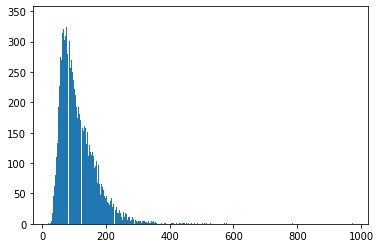

In [567]:
# Number of sentences in documents along x
# Number of documents with x number of sentences along y
plt.hist(sentences_plot, bins=1000)

### 3.2 Sentence Wise-Preprocessing
Attempting to remove noise from document, like punctuations, numerical values, and whitespaces

In [249]:
def from_unrefined_to_refined_tokens(token_list):
    
    txt = ''
    
    for i in range(len(token_list)):
        if i <= len(token_list)-1:
            txt += token_list[i]+' '
        else:
            txt+= token_list[i]
    
    doc = nlp(txt)
    tokens = list(doc)
    
    clean_tokens = []
    year = re.compile("^(19|20)\d{2}$") # Matching Years 19XX and 20XX
    alpha_numeric = re.compile("^[0-9]{1,3}[a-z]$") # Citation Text

    for t in tokens:
        
        if t.pos_ == 'PUNCT':
            pass
        
        elif t.is_space:
            pass
        
        elif year.match(t.text):
            clean_tokens.append('<YEAR>')
            
        elif alpha_numeric.match(t.text):
            clean_tokens.append('<ALP-NUM>')
            
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
            
        else:
            clean_tokens.append(t.lower_)
            
    return clean_tokens

In [250]:
def from_sent_to_unrefined_tokens(sent):
    
    tokens = nlp(sent)
    txt=''
    
    for i in range(len(tokens)):
        if i<=len(tokens)-1:
            #txt+=tokens[i].text+' '
            txt+=tokens[i].orth_+ ' '
        else:
            #txt+=tokens[i].text
            txt+=tokens[i].orth_
            
    dirty_tokens = re.split('\s+', txt)  # split words
    # remove all non-alphanumerics
    clean_tokens = [re.sub(r'\W', '', t) 
                    for t in dirty_tokens]
    if '' in clean_tokens:  # remove empty tokens
        clean_tokens.remove('')
    return clean_tokens

In [251]:
len(corpus)

30000

### 3.2 Sentence-wise Preprocessing

In [252]:
def tokenize_corpus(corpus): 
    tokens_of_corpus = list()
    for doc in corpus:
        tokens_of_sentences = list()
        for sent in text2sentences(doc['plainText']): ## Done using luima
            unrefined_tokens = from_sent_to_unrefined_tokens(sent)
            if (len(unrefined_tokens)) <=5:
                continue
            refined_tokens = from_unrefined_to_refined_tokens(unrefined_tokens)
            if (len(refined_tokens)) <=5:
                continue
            else:
                tokens_of_sentences.append(refined_tokens)
        tokens_of_corpus.append(tokens_of_sentences)
    return tokens_of_corpus

#### Example Tokenized Sentences

In [259]:
corpus1 = corpus[0:2]
tokenized_corpus_1 = tokenize_corpus(corpus1)

In [572]:
tokenized_corpus_1[0][15] ## Converting Numbers to <NUMx> 

['see', 'dingess', 'hartman', '<NUM2>', 'vet', 'app', '<NUM3>']

In [268]:
tokenized_corpus_1[0][8] # Converting Numbers to <NUMx> 

['<NUM2>',
 'usca',
 '<NUM4>',
 '<NUM4>',
 '5103a',
 'west',
 '<YEAR>',
 '<NUM2>',
 'cfr',
 '<NUM4>',
 '<NUM4>',
 '<YEAR>']

In [136]:
#tokens_of_corpus = tokens_of_corpus + tokenize_corpus(corpus[10000:30000])

In [137]:
#len(tokens_of_corpus)

In [138]:
#random.shuffle(tokens_of_corpus)

In [547]:
# Don't run again !
# *** Appending new entries to the file with each pass of "corpus"
# with open('TokenizedSentences_Luima.txt', 'a') as File_of_Tokenized_Sentences:
#     for file in tokens_of_corpus:
#         random.shuffle(file)
#         for sentence in file:
#             for token in sentence:
#                 File_of_Tokenized_Sentences.write(token+" ")
#             File_of_Tokenized_Sentences.write("\n")
# File_of_Tokenized_Sentences.close()

In [256]:
File_of_Tokenized_Sentences_Luima = open("TokenizedSentences_Luima.txt", "r")
#File_of_Tokenized_Sentences_Spacy = open("Tokenized_Sentences.txt", "r")
line_count = 0
for line in File_of_Tokenized_Sentences_Luima:
    if line != "\n":
        line_count += 1
File_of_Tokenized_Sentences_Luima.close()

print("Number of sentences", line_count) # Number of sentences 2,583,919(luima), 2,466,655(SpaCy)

Number of sentences 2583919


In [269]:
# File_of_Tokenized_Sentence_Luima = open("TokenizedSentences_Luima.txt", "r")

In [141]:
# File_of_Tokenized_Sentences = open("TokenizedSentences_Luima.txt", "r")
# lines = File_of_Tokenized_Sentences.readlines()
# lines[694196]

In [142]:
# Used once, never again *********
# with open('corpus.json', 'w') as f:
#     json.dump(corpus, f)

In [143]:
len(corpus)

30000

In [145]:
# corpus_fpath = 'corpus.json'
# corpus_from_json = json.load(open(corpus_fpath))

In [148]:
# #list_of_all_sentences[0] ## Was made to create a file with randomly ordered sentences
#                          # when creating the file of tokenized sentences
#                          # remove all sentences less than 5 tokens long
# tokens_of_sentences_from_doc = list()
# list_of_all_sentences[0] = random.shuffle(list_of_all_sentences[0])
# for sent in nlp(list_of_all_sentences[0]).sents:
#     unrefined_tokens = from_sent_to_unrefined_tokens(sent)
#     refined_tokens = from_unrefied_to_refined_tokens(unrefined_tokens)
#     tokens_of_sentences_from_doc.append(refined_tokens)
    

In [149]:
# ####**** Do not run this again !!
# from multiprocessing.dummy import Pool as ThreadPool
# pool = ThreadPool(16)
# list_of_all_sentences = list()
# list_of_all_sentences.extend(pool.map(docs_to_sentences, corpus))

In [150]:
# from multiprocessing.dummy import Pool as ThreadPool
# pool = ThreadPool()
# tokens_of_corpus = tokenize_corpus(corpus)

In [152]:
## Do not delete !!
# count_of_tokens_per_sentence = list()
# for doc_tokens in tokens_of_corpus:
#     for sentence_tokens in doc_tokens:
#         count_of_tokens_per_sentence.append(len(sentence_tokens))

Initialize once `(tokens_of_corpus = list())` and 
`count_of_tokens_per_sentence = list()`, then use multiple times, each time add new corpus entries that have their individual sentences tokenised into a list of tokens.

In [156]:
# tokens_of_corpus = list()x
# count_of_tokens_per_sentence = list()

In [157]:
# Do not delete !!
# for doc in corpus_segments:
#     tokens_of_sentences_per_doc = list()
#     for sent in nlp(doc['plainText']).sents:
#         unrefined_tokens = from_sent_to_unrefined_tokens(sent)
#         refined_tokens = from_unrefined_to_refined_tokens(unrefined_tokens)
#         tokens_of_sentences_per_doc.append(refined_tokens)
#     tokens_of_corpus.append({'name':doc['name'], 'tokens': tokens_of_sentences_per_doc})

In [159]:
#len(tokens_of_corpus)

In [633]:
# #Used once, never again *********
# with open('TokenizedSentencesOfCorpus_Luima.json', 'w') as f:
#      json.dump(tokens_of_corpus, f)

In [ ]:
# #Used once, never again *********
# with open('TokenizedSentencesOfCorpus_Spacy.json', 'w') as f:
#      json.dump(tokens_of_corpus, f)

### 3.3 Tokenize Unlabeled Data
Retrieveing tokenized data that was tokenized earlier using:
* Spacy Sentence Segmention + Augmented Spacy Tokenization = "TokenizedSentencesOfCorpus_Spacy.json"
* Luima Sentence Segmentation + Augmented Spacy Tokenization = "TokenizedSentencesOfCorpus_Luima.json"


In [160]:
tokenized_fpath = 'TokenizedSentencesOfCorpus_Spacy.json'
tokenized_corpus_spacy = json.load(open(tokenized_fpath))

In [270]:
tokenized_fpath = 'TokenizedSentencesOfCorpus_Luima.json'
tokenized_corpus_luima = json.load(open(tokenized_fpath))

In [618]:
#tokenized_corpus_luima[0][0:5]

In [162]:
len(tokenized_corpus_luima)

30000

In [272]:
count_of_tokens_per_sentence = list()

In [273]:
for doc_tokens in tokenized_corpus_luima:
    for sentence_tokens in doc_tokens:
        count_of_tokens_per_sentence.append(len(sentence_tokens))

In [274]:
print("The total number of tokens in the corpus is", sum(count_of_tokens_per_sentence)) #62,654,516  for SpaCy
                                                                                         #59,429,980 for Luima

The total number of tokens in the corpus is 59429980


In [275]:
# with open('Tokenized_Sentences.txt', 'a') as File_of_Tokenized_Sentences:
#     for file in shuffled_tokenized_file:
#         random.shuffle(file)
#         for sentence in file:
#             for token in sentence:
#                 File_of_Tokenized_Sentences.write(token+" ")
#             File_of_Tokenized_Sentences.write("\n")
# File_of_Tokenized_Sentences.close()

In [284]:
print("Total number of tokens in 30,000 cases: ", sum(count_of_tokens_per_sentence))

Total number of tokens in 30,000 cases:  59429980


In [578]:
print("Median number of tokens per sentence in 30,000 cases:", statistics.median(count_of_tokens_per_sentence))
print("Maximum number of tokens per sentence in entire corpus of 30,000 cases :" ,max(count_of_tokens_per_sentence))
      

Median number of tokens per sentence in 30,000 cases: 20
Maximum number of tokens per sentence in entire corpus of 30,000 cases : 467


### 3.3 Histogram of Number of Tokens in each Sentence

(array([4.68041e+05, 4.50681e+05, 3.43647e+05, 3.59663e+05, 2.93496e+05,
        1.82154e+05, 1.58803e+05, 9.72310e+04, 7.92110e+04, 5.12060e+04,
        2.81330e+04, 2.25960e+04, 1.23430e+04, 1.16470e+04, 7.59300e+03,
        4.02000e+03, 3.20900e+03, 2.15900e+03, 2.09500e+03, 1.44600e+03,
        7.59000e+02, 1.38000e+03, 6.70000e+02, 3.64000e+02, 3.40000e+02,
        2.13000e+02, 1.95000e+02, 1.20000e+02, 8.00000e+01, 7.40000e+01,
        3.70000e+01, 6.20000e+01, 1.90000e+01, 5.80000e+01, 3.00000e+01,
        9.00000e+00, 9.00000e+00, 1.90000e+01, 4.00000e+00, 6.00000e+00,
        1.10000e+01, 1.30000e+01, 1.20000e+01, 8.00000e+00, 6.00000e+00,
        8.00000e+00, 6.00000e+00, 1.00000e+00, 6.00000e+00, 1.00000e+00,
        5.00000e+00, 4.00000e+00, 3.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 2.00

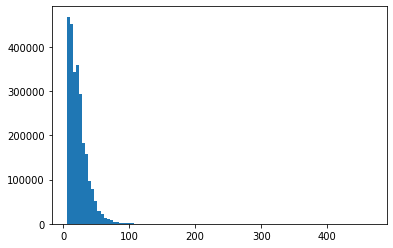

In [580]:
plt.hist(count_of_tokens_per_sentence, bins=100)

## Phase 4: Developing Word Embeddings


In [169]:
!pip install -U gensim

In [286]:
import fasttext
# from gensim.models import FastText
# model = FastText(vector_size=100, min_count = 20)
#model = fasttext.train_unsupervised('TokenizedSentences_Luima.txt')
model = fasttext.load_model("model_luima.bin")

In [287]:
# Don't run again *********
# model.train(File_of_Tokenized_Sentence_Luima, total_examples=model.corpus_count, epochs =15)

In [288]:
#model.save_model("model_luima.bin")

In [291]:
print("Total unique words detected by FastText in 30,000 cases :",len(model.words) )#27,159 (SpaCy)  # 26,356 (Luima)
      

Total unique words detected by FastText in 30,000 cases : 26356


### 4.2 Evaluating Custom Embeddings Manually

### Examining Patterns from BVA decisions 

In [601]:
model.get_nearest_neighbors("veteran")

[(0.7261703014373779, 'the'),
 (0.716791033744812, 'appellant'),
 (0.7145872712135315, 'theveteran'),
 (0.6986010670661926, 's'),
 (0.6527009010314941, 'his'),
 (0.6403632164001465, 'additionally'),
 (0.6275529265403748, 'bhat'),
 (0.6255661249160767, 'he'),
 (0.6187827587127686, 'jbm'),
 (0.6110667586326599, 'moreover')]

In [582]:
model.get_nearest_neighbors("v.")

[(0.3159726560115814, 'versions'),
 (0.28894317150115967, 'oct'),
 (0.28559401631355286, 'fixed'),
 (0.26697564125061035, '2c08'),
 (0.2539653480052948, 'noting'),
 (0.253465473651886, 'deterioration'),
 (0.25342032313346863, 'vaopgcrec'),
 (0.2531037926673889, 'recovering'),
 (0.25300052762031555, 'vaopgprec'),
 (0.2500399947166443, 'vaopgcprec')]

In [583]:
model.get_nearest_neighbors("argues")

[(0.845245897769928, 'asserts'),
 (0.8363192677497864, 'contends'),
 (0.8183647394180298, 'contending'),
 (0.7825031876564026, 'asserted'),
 (0.7688855528831482, 'alleges'),
 (0.7575464248657227, 'maintains'),
 (0.7257305979728699, 'contended'),
 (0.7187284231185913, 'argued'),
 (0.6857544183731079, 'believes'),
 (0.6815640926361084, 'contention')]

In [584]:
model.get_nearest_neighbors("ptsd")

[(0.7550228238105774, 'pstd'),
 (0.7458516955375671, 'depressive'),
 (0.7229285836219788, 'mdd'),
 (0.7206199169158936, 'anxiety'),
 (0.7132626175880432, 'mst'),
 (0.7091643810272217, 'psychiatric'),
 (0.7087100148200989, 'stressors'),
 (0.6994684338569641, 'dysthymic'),
 (0.692949116230011, 'depression'),
 (0.684861421585083, 'bipolar')]

In [585]:
model.get_nearest_neighbors("granted")

[(0.6785476207733154, 'connection'),
 (0.5455173850059509, 'entitlement'),
 (0.53980952501297, 'incurred'),
 (0.5378241539001465, 'grants'),
 (0.533177375793457, 'connections'),
 (0.5322375297546387, 'diagnosed'),
 (0.5300636291503906, 'proximately'),
 (0.52934330701828, 'warranted'),
 (0.5261068344116211, 'may'),
 (0.5240494012832642, 'denied')]

In [586]:
model.get_nearest_neighbors("korea")

[(0.831130862236023, 'korean'),
 (0.7852842211723328, 'dmz'),
 (0.7724472284317017, 'panama'),
 (0.7723371982574463, 'germany'),
 (0.7709794640541077, 'demilitarized'),
 (0.7626539468765259, 'vietnam'),
 (0.760360062122345, 'okinawa'),
 (0.7320035696029663, 'stationed'),
 (0.7309944033622742, 'tour'),
 (0.7162233591079712, 'taegu')]

In [587]:
model.get_nearest_neighbors("holding")

[(0.8356209993362427, '2007holding'),
 (0.8307411074638367, '2013holding'),
 (0.798393964767456, '2006holding'),
 (0.728683590888977, 'v'),
 (0.7271729707717896, 'app'),
 (0.7214847207069397, 'vet'),
 (0.7164319157600403, 'holdings'),
 (0.6820679903030396, 'app439'),
 (0.665960967540741, 'cir2007'),
 (0.6656458973884583, 'f3d')]

In [611]:
model.get_nearest_neighbors("also")

[(0.6292423605918884, '<YEAR>'),
 (0.5860716700553894, 'atd'),
 (0.5750747919082642, 'see'),
 (0.5730634331703186, 'mcknight'),
 (0.5635877251625061, 'prinicpi'),
 (0.5616952180862427, 'mcneely'),
 (0.5608793497085571, 'nolen'),
 (0.5540839433670044, 'addition'),
 (0.5519648194313049, 'diorio'),
 (0.5508466958999634, 'klekar')]

<b>Evaluating 3 additional random tokens</b>

In [589]:
model.get_nearest_neighbors("Soviet")

[(0.9529984593391418, 'soviet'),
 (0.7975742816925049, 'russian'),
 (0.7916305065155029, 'japanese'),
 (0.7790541648864746, 'russians'),
 (0.7722088098526001, 'refugee'),
 (0.7707417011260986, 'libyan'),
 (0.770624577999115, 'bombings'),
 (0.7672246098518372, 'iranian'),
 (0.7656106352806091, 'viet'),
 (0.7643221616744995, 'refugees')]

In [590]:
model.get_nearest_neighbors("injury")

[(0.7053062915802002, 'disease'),
 (0.7041248679161072, 'injuryies'),
 (0.6572684645652771, 'reinjury'),
 (0.6375981569290161, 'disability'),
 (0.6372613310813904, 'incurrent'),
 (0.6236783266067505, 'aggravated'),
 (0.6222447752952576, 'reaggravated'),
 (0.6139276027679443, 'crush'),
 (0.6138746738433838, 'incurred'),
 (0.6086045503616333, 'injuries')]

In [324]:
model.get_nearest_neighbors('suicidal')

[(0.969139814376831, 'ideation'),
 (0.9417762160301208, 'suicidality'),
 (0.937765896320343, 'homicidal'),
 (0.9333791732788086, 'ideations'),
 (0.9094842076301575, 'homicidality'),
 (0.8403745293617249, 'hallucinations'),
 (0.8362619280815125, 'hallucination'),
 (0.8264451026916504, 'paranoia'),
 (0.8172924518585205, 'homicide'),
 (0.815589964389801, 'delusions')]

In [602]:
len(model.get_word_vector("suicidal"))

100

In [323]:
choice = random.choice(corpus)
choice['plainText']

"Citation Nr: 0822700\t\nDecision Date: 07/10/08    Archive Date: 07/14/08\n\nDOCKET NO.  05-22 130\t)\tDATE\n\t)\n\t)\n\nOn appeal from the\nDepartment of Veterans Affairs Regional Office in \nAlbuquerque, New Mexico\n\n\nTHE ISSUE\n\nEntitlement to service connection for a psychiatric \ndisability, to include generalized anxiety disorder and \nintermittent explosive disorder.\n\n\nREPRESENTATION\n\nAppellant represented by:\tDisabled American Veterans\n\n\nATTORNEY FOR THE BOARD\n\nDavid Ganz, Associate Counsel\n\n\nINTRODUCTION\n\nThe veteran had active military service from September 1968 \nto August 1991.\n\nThis matter comes to the Board of Veterans' Appeals (Board) \nfrom an August 2004 rating decision by the Department of \nVeterans Affairs (VA) Regional Office (RO) in Albuquerque, \nNew Mexico, which, in pertinent part, denied entitlement to \nservice connection for a generalized anxiety disorder, \nclaimed as stress and anger problems, right knee degenerative \njoint disease,

In [593]:
model.get_nearest_neighbors('insomnia')

[(0.8481608629226685, 'dyssomnia'),
 (0.8235304951667786, 'restlessness'),
 (0.8155633211135864, 'anxiety'),
 (0.8150708079338074, 'hypersomnia'),
 (0.811242938041687, 'depression'),
 (0.8110232353210449, 'irritability'),
 (0.8026850819587708, 'sleeplessness'),
 (0.8001810312271118, 'nervousness'),
 (0.7977856397628784, 'swings'),
 (0.7892727851867676, 'parasomnia')]

From examining the above randomly generated document we see that the token "suicidal" naturally appears with in the context of the words "paranoia", "delusions", "hallucinations" etc.

From the above generated case text, examining words within the neighborhood of "insomnia" generates a word list consisting of "sleeplessness" and "parasomnia" which are naturally found in the context of "insomnia" from the above case text.

In [186]:
# doc = nlp(train_sentences[0])
# list(doc)
# sentence_vector= list()
# for word in list(doc):
#     sentence_vector.append(model.get_word_vector(word.text))

## Phase 5: Training Classifiers
### TFIDF Featurization

In [329]:
types = data['types']

In [330]:
train_sentences = list()
train_types = list()
train_sentence_normalized_start = list()
for annotation in annotations:
    for document in train_documents:
        if annotation['document'] == document['_id']:
            for annotation_type in types:
                if annotation['type'] == annotation_type['_id']:
                    train_types.append(annotation_type['name'])
                    train_sentences.append(document['plainText'][annotation['start']: annotation['end']])
                    train_sentence_normalized_start.append(annotation['start']/((float)(len(document['plainText']))))

In [331]:
# with open('TrainVectorizer.txt', 'w') as For_Analyze_File:
#     for sentence in train_sentences:
#         For_Analyze_File.write(sentence+"\n")
# For_Analyze_File.close()
#     for file in shuffled_tokenized_file:
#         random.shuffle(file)
#         for sentence in file:
#             for token in sentence:
#                 File_of_Tokenized_Sentences.write(token+" ")
#             File_of_Tokenized_Sentences.write("\n")
# File_of_Tokenized_Sentences.close()

In [332]:
counter = 0
for i in range(len(train_sentence_normalized_start)):
    if train_sentence_normalized_start[i] == 0.0:
        counter+=1

In [623]:
# print("Checking to see if number of start positions equal to 0 is in line with the number of train documents:", counter)


In [339]:
len(train_types)

12385

In [198]:
len(test_documents)

14

In [340]:
test_sentences = list()
test_types = list()
test_sentence_normalized_start = list()
for annotation in annotations:
    for document in test_documents:
        if annotation['document'] == document['_id']:
            for annotation_type in types:
                if annotation['type'] == annotation_type['_id']:
                    test_types.append(annotation_type['name'])
                    test_sentences.append(document['plainText'][annotation['start']: annotation['end']])
                    test_sentence_normalized_start.append(annotation['start']/((float)(len(document['plainText']))))

In [341]:
counter = 0
for i in range(len(test_sentence_normalized_start)):
    if test_sentence_normalized_start[i] == 0.0:
        counter+=1

In [342]:
counter

14

In [343]:
len(test_sentences)

1524

In [344]:
len(test_types)

1524

In [345]:
dev_sentences = list()
dev_types = list()
dev_sentence_normalized_start = list()
for annotation in annotations:
    for document in dev_documents:
        if annotation['document'] == document['_id']:
            for annotation_type in types:
                if annotation['type'] == annotation_type['_id']:
                    dev_types.append(annotation_type['name'])
                    dev_sentences.append(document['plainText'][annotation['start']: annotation['end']])
                    dev_sentence_normalized_start.append(annotation['start']/((float)(len(document['plainText']))))

In [346]:
len(dev_sentence_normalized_start)

1440

In [347]:
test_sentence_normalized_start[0:8]

[0.9899894298327426,
 0.013368152707828141,
 0.019399365789964557,
 0.02400049741963564,
 0.027668967232481502,
 0.046260026114530874,
 0.06024995336690916,
 0.0693900391717963]

In [348]:
type(dev_types[0:19])

list

In [349]:
len(dev_types)

1440

In [211]:
len(dev_sentences)

1440

The total annotaions is 15349  
12385+1440+1524=15349  

### 5.1 TFIDF Featurization

In [350]:
annotations = data['annotations']


In [510]:
def spacy_tokenize(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            clean_tokens.append(t.lemma_)
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [352]:
train_sentences[0:3]

['Citation Nr: 1615107\t\r\nDecision Date: 04/13/16    Archive Date: 04/26/16\r\n\r\nDOCKET NO.  12-17 771\t)\tDATE\r\n\t)\r\n\t)',
 'On appeal from the\r\nDepartment of Veterans Affairs Regional Office in Portland, Oregon',
 'THE ISSUE']

In [355]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)

In [356]:
## Train set TFIDF Feature generation
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,1))
spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_sentences)
dump(spacy_tfidf_vectorizer, 'vectorizer_model.joblib')

['vectorizer_model.joblib']

In [424]:
spacy_tfidf_vectorizer

TfidfVectorizer(min_df=3, tokenizer=<function spacy_tokenize at 0x7f82651a8d30>)

### 5.2 Word Embedding Featurization

### Averaged Sentence Embedding

In [357]:
import sys
print(sys.float_info.max)
max_value = sys.float_info.max
min_value = sys.float_info.min

1.7976931348623157e+308


In [358]:
print(sys.float_info.min)

2.2250738585072014e-308


In [359]:
type(max_value)

float

In [360]:
def generate_sentence_embedding(sentence):
    doc = nlp(sentence)
    embedding_vector = np.zeros([100,])
    for word in list(doc):
        embedding_vector += np.nan_to_num(model.get_word_vector(word.text))
    return np.nan_to_num(embedding_vector/len(list(doc)))

In [361]:
train_sentences[12219]

'A veteran as a lay person is competent to offer an opinion on a simple medical condition.'

In [362]:
train_sentence_embeddings = np.empty([len(train_sentences), 100])
for i in range(len(train_sentences)):
    train_sentence_embeddings[i] = generate_sentence_embedding(train_sentences[i])

In [363]:
for i in range(len(train_sentences)):
    for j in range(100):
        if train_sentence_embeddings[i][j] >= max_value:
            train_sentence_embeddings[i][j] = max_value*0.0001
        if train_sentence_embeddings[i][j] <= min_value:
            train_sentence_embeddings[i][j] = min_value

In [364]:
train_sentence_embeddings.shape

(12385, 100)

In [365]:
dev_sentence_embeddings = np.empty([len(dev_sentences), 100])
for i in range(len(dev_sentences)):
    dev_sentence_embeddings[i] = generate_sentence_embedding(dev_sentences[i])

In [366]:
for i in range(len(dev_sentences)):
    for j in range(100):
        if dev_sentence_embeddings[i][j] > max_value:
            dev_sentence_embeddings[i][j] = max_value*0.0001
        if dev_sentence_embeddings[i][j] < min_value:
            dev_sentence_embeddings[i][j] = min_value

In [367]:
dev_sentence_embeddings.shape

(1440, 100)

In [368]:
test_sentence_embeddings = np.empty([len(test_sentences), 100])
for i in range(len(dev_sentences)):
    test_sentence_embeddings[i] = generate_sentence_embedding(test_sentences[i])

In [369]:
for i in range(len(test_sentences)):
    for j in range(100):
        if test_sentence_embeddings[i][j] > max_value:
            test_sentence_embeddings[i][j] = max_value*0.0001
        if test_sentence_embeddings[i][j] < min_value:
            test_sentence_embeddings[i][j] = min_value

In [370]:
test_sentence_embeddings.shape

(1524, 100)

### Normalized number of Tokens per sentence

In [371]:
# Number of tokens per each sentence in train_sentences
number_train_sentence_tokens = list()
for i in range(len(train_sentences)):
    doc = nlp(train_sentences[i])
    number_train_sentence_tokens.append(len(list(doc)))

In [372]:
# Number of tokens per each sentence in dev_sentences
number_dev_sentence_tokens = list()
for i in range(len(dev_sentences)):
    doc = nlp(dev_sentences[i])
    number_dev_sentence_tokens.append(len(list(doc)))

In [373]:
# Number of tokens per each sentence in dev_sentences
number_test_sentence_tokens = list()
for i in range(len(test_sentences)):
    doc = nlp(test_sentences[i])
    number_test_sentence_tokens.append(len(list(doc)))

In [374]:
number_train_sentence_tokens[0:2]

[31, 15]

In [375]:
len(number_test_sentence_tokens)

1524

In [377]:
len(number_dev_sentence_tokens)

1440

In [378]:
len(number_train_sentence_tokens)

12385

In [379]:
import statistics
std_dev1 = statistics.pstdev(number_train_sentence_tokens)
std_dev2 = statistics.pstdev(number_dev_sentence_tokens)
std_dev3 = statistics.pstdev(number_test_sentence_tokens)
print("Standard deviation of the given train sentences: " + str(std_dev1))
print("Standard deviation of the given dev sentences: " + str(std_dev2))
print("Standard deviation of the given test sentences: " + str(std_dev3))

Standard deviation of the given train sentences: 18.78479069981811
Standard deviation of the given dev sentences: 18.343690203806045
Standard deviation of the given test sentences: 19.70182941003048


In [380]:
average_sentence_length_train = sum(number_train_sentence_tokens)/(float)(len(number_train_sentence_tokens))

In [381]:
average_sentence_length_dev = sum(number_dev_sentence_tokens)/(float)(len(number_dev_sentence_tokens))

In [382]:
average_sentence_length_test = sum(number_test_sentence_tokens)/(float)(len(number_test_sentence_tokens))

In [383]:
normalized_tokens_per_sentence_dev = list()
for i in range(len(dev_sentences)):
    doc = nlp(dev_sentences[i])
    normalized_tokens_per_sentence_dev.append((len(list(doc))-average_sentence_length_dev)/std_dev2)

In [384]:
normalized_tokens_per_sentence_train = list()
for i in range(len(train_sentences)):
    doc = nlp(train_sentences[i])
    normalized_tokens_per_sentence_train.append((len(list(doc))-average_sentence_length_train)/std_dev1)

In [385]:
normalized_tokens_per_sentence_test = list()
for i in range(len(test_sentences)):
    doc = nlp(test_sentences[i])
    normalized_tokens_per_sentence_test.append((len(list(doc))-average_sentence_length_test)/std_dev3)

In [386]:
len(normalized_tokens_per_sentence_dev)

1440

#### Creating Feature Vectors

In [388]:
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_sentences).toarray()
dev_tfidf_spacy = spacy_tfidf_vectorizer.transform(dev_sentences).toarray()

In [389]:
test_tfidf_spacy = spacy_tfidf_vectorizer.transform(test_sentences).toarray()

In [390]:
max(test_tfidf_spacy[999])

0.6279302527125934

In [391]:
print("Train sentences are vectorized as ",train_tfidf_spacy.shape)

Train sentences are vectorized as  (12385, 3082)


In [392]:
print("Dev sentences are vectorized as ",dev_tfidf_spacy.shape)


Dev sentences are vectorized as  (1440, 3082)


In [393]:
print("Test sentences are vectorized as ",test_tfidf_spacy.shape)


Test sentences are vectorized as  (1524, 3082)


In [394]:
type(train_tfidf_spacy)

numpy.ndarray

In [395]:
spacy_tfidf_vectorizer.idf_[spacy_tfidf_vectorizer.vocabulary_["abdomen"]]

9.038027720378116

# Results

## 5.3 Model Training

In total 24 models are trained, 12 each for the TFIDF-Concatenated Features and the Embedding-Vectors Concatenated Features
The models include:
<ol>
    <li> "Rbf" SVM Kernel</li>
    <li> "Poly" SVM Kernel</li>
    <li> "Linear" SVM Kernel</li>
    <li> Random Forest with 25 Trees and Depth of 10 </li>
    <li> Random Forest with 25 Trees and Depth of 16 </li>
    <li> Random Forest with 25 Trees and Depth of 24 </li>
    <li> Random Forest with 50 Trees and Depth of 10 </li>
    <li> Random Forest with 50 Trees and Depth of 16 </li>
    <li> Random Forest with 50 Trees and Depth of 24 </li>
    <li> Random Forest with 100 Trees and Depth of 20 </li>
    <li> Decision Tree with Depth of 20 </li>
    <li> Logistic Regression Classifier </li>
</ol>
    
<p>The best performing model is the <b>Logistic Regression Classifier (86% F1)</b> with <i>TFIDF-Concatenated Features</i> used for training. This model achieves a <b>78% F1-Score on the unseen Test-Set.</b></p>
    <p> The second best performing model is the <b> Rbf SVM Kernel (85% F1) </b> with  <i> Embedding Vector Concatenated Features </i> used for training. This model achieves a <b>73% F1-Score on the unseen Test-Set.</b></p>

<center><h3>Table of Results</h3></center>


| Model Name  | Precision (on dev)  | Recall (on dev)  |  F1-Score (on dev) |
|---|---|---|---|
| Radial SVM (TFIDF) | 79%  | 80%  | 79%  |   
| Radial SVM (Emb)  | <b>84%</b>  | <b>85%</b>  | <b>84%</b>  |   
| Poly SVM (TFIDF) | 57%  | 44%  | 37%  |   
| Poly SVM (Emb)  | 77%  | 79%  | 76%  |
| Linear SVM (TFIDF)  | 81%  | 80%   | 81%  |
| Linear SVM (Emb)  | 83%  | 84% | 84%  |
| Random Forest(25T, 10D) (TFIDF)  | 72%  | 71%   | 65%  |
| Random Forest (25T, 10D) (Emb) | 78%  | 82%   | 79%  |
| Random Forest (25T, 16D) (TFIDF) | 77% | 76% | 71% |
| Random Forest (25T, 16D) (Emb) | 81% | 83% | 81% |
| Random Forest (25T, 24D) (TFIDF)  | 81%  | 81%   | 79%  |
| Random Forest (25T, 24D) (Emb)  | 81%  | 83%   | 82%  |
| Random Forest (50T, 10D) (TFIDF)  | 70%  | 70%   | 63%  |
| Random Forest (50T, 10D) (Emb)  | 83%  |  82%  | 79%  |
| Random Forest (50T, 16D) (TFIDF) | 78%  | 76%   | 72% |
| Random Forest (50T, 16D) (Emb)  | 80%  | 83%  | 81%  |
| Random Forest (50T, 24D) (TFIDF) | 80%  | 82%  | 79%  |
| Random Forest (50T, 24D) (Emb)  | 82%  | 84%  | 82%  |
| Random Forest (100T, 20D) (TFIDF) | 78%  | 79%  | 76%  |
| Random Forest (100T, 20D) (Emb)  | 82%  | 84%  | 82%  |
| Decision Tree (18D) (TFIDF)  | 78%  | 78%   | 78%  |
| Decision Tree (18D) (Emb) | 76%  | 75%   | 75%  |
| Logistic Regression (TFIDFI)  | <b>85%</b>  | <b>86%</b>   | <b>85%</b> |
| Logistic Regression (Emb)  | 80%  | 82%   |80%   |

In [396]:
train_sentence_normalized_start = np.array(train_sentence_normalized_start)
normalized_tokens_per_sentence_train = np.array(normalized_tokens_per_sentence_train)
X_train_TFIDF = np.concatenate((train_tfidf_spacy, np.expand_dims(train_sentence_normalized_start, axis=1), np.expand_dims(normalized_tokens_per_sentence_train, axis=1)), axis=1)


In [397]:
dev_sentence_normalized_start = np.array(dev_sentence_normalized_start)
normalized_tokens_per_sentence_dev = np.array(normalized_tokens_per_sentence_dev)
X_dev_TFIDF = np.concatenate((dev_tfidf_spacy, np.expand_dims(dev_sentence_normalized_start, axis=1), np.expand_dims(normalized_tokens_per_sentence_dev, axis=1)), axis=1)


In [398]:
test_sentence_normalized_start = np.array(test_sentence_normalized_start)
normalized_tokens_per_sentence_test = np.array(normalized_tokens_per_sentence_test)
X_test_TFIDF = np.concatenate((test_tfidf_spacy, np.expand_dims(test_sentence_normalized_start, axis=1), np.expand_dims(normalized_tokens_per_sentence_test, axis=1)), axis=1)


In [399]:
X_train_Emb = np.concatenate((train_sentence_embeddings, np.expand_dims(train_sentence_normalized_start, axis=1), np.expand_dims(normalized_tokens_per_sentence_train, axis=1)), axis=1)
X_dev_Emb = np.concatenate((dev_sentence_embeddings, np.expand_dims(dev_sentence_normalized_start, axis=1), np.expand_dims(normalized_tokens_per_sentence_dev, axis=1)), axis=1)


In [400]:
X_test_Emb = np.concatenate((test_sentence_embeddings, np.expand_dims(test_sentence_normalized_start, axis=1), np.expand_dims(normalized_tokens_per_sentence_test, axis=1)), axis=1)


In [401]:
X_train_TFIDF.shape

(12385, 3084)

In [402]:
X_dev_TFIDF.shape

(1440, 3084)

In [403]:
X_train_Emb.shape

(12385, 102)

In [404]:
X_dev_Emb.shape

(1440, 102)

In [405]:
X_test_TFIDF.shape

(1524, 3084)

In [406]:
X_test_Emb.shape

(1524, 102)

In [407]:
type(dev_types)

list

In [408]:
train_types = np.array(train_types)
dev_types = np.array(dev_types)

In [409]:
train_types

array(['CaseHeader', 'Procedure', 'Header', ...,
       'EvidenceBasedOrIntermediateFinding',
       'EvidenceBasedOrIntermediateFinding', 'Citation'], dtype='<U34')

In [410]:
dev_types

array(['CaseHeader', 'CaseFooter', 'Header', ...,
       'EvidenceBasedReasoning', 'EvidenceBasedReasoning',
       'EvidenceBasedOrIntermediateFinding'], dtype='<U34')

In [411]:
dev_types.shape

(1440,)

In [412]:
X_train_TFIDF.shape

(12385, 3084)

In [413]:
dev_types

array(['CaseHeader', 'CaseFooter', 'Header', ...,
       'EvidenceBasedReasoning', 'EvidenceBasedReasoning',
       'EvidenceBasedOrIntermediateFinding'], dtype='<U34')

In [414]:
clf_default_TFIDF = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
clf_default_TFIDF.fit(X_train_TFIDF, train_types)
print('TRAIN rbf kernel:\n'+classification_report(train_types, clf_default_TFIDF.predict(X_train_TFIDF)))
print('TEST rbf kernel:\n'+classification_report(dev_types, clf_default_TFIDF.predict(X_dev_TFIDF)))

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN rbf kernel:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       0.95      0.82      0.88       115
                          Citation       0.99      0.99      0.99      1953
                   ConclusionOfLaw       0.88      0.86      0.87       272
                          Evidence       0.90      0.98      0.94      3716
EvidenceBasedOrIntermediateFinding       0.86      0.89      0.87      1179
            EvidenceBasedReasoning       0.95      0.62      0.75       847
                            Header       0.99      0.98      0.99      1192
                         LegalRule       0.92      0.97      0.95      1582
              LegislationAndPolicy       0.88      0.42      0.57       146
              PolicyBasedReasoning       0.00      0.00      0.00    

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [415]:
clf_default_Emb = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
clf_default_Emb.fit(X_train_Emb, train_types)
print('TRAIN rbf kernel:\n'+classification_report(train_types, clf_default_Emb.predict(X_train_Emb)))
print('TEST rbf kernel:\n'+classification_report(dev_types, clf_default_Emb.predict(X_dev_Emb)))

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN rbf kernel:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       0.99      0.96      0.98       114
                         CaseIssue       0.93      0.97      0.95       115
                          Citation       0.97      0.97      0.97      1953
                   ConclusionOfLaw       0.90      0.83      0.87       272
                          Evidence       0.83      0.94      0.88      3716
EvidenceBasedOrIntermediateFinding       0.70      0.64      0.67      1179
            EvidenceBasedReasoning       0.63      0.35      0.45       847
                            Header       0.98      0.99      0.99      1192
                         LegalRule       0.85      0.93      0.89      1582
              LegislationAndPolicy       0.76      0.31      0.44       146
              PolicyBasedReasoning       0.00      0.00      0.00    

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [416]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='poly'))

In [417]:
clf.fit(X_train_TFIDF, train_types)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='poly'))])

In [418]:
print('TRAIN Poly kernel:\n'+classification_report(train_types, clf.predict(X_train_TFIDF)))
print('TEST Poly kernel:\n'+classification_report(dev_types, clf.predict(X_dev_TFIDF)))

TRAIN Poly kernel:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.36      0.53       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       0.94      0.13      0.23       115
                          Citation       0.96      0.43      0.59      1953
                   ConclusionOfLaw       0.83      0.16      0.27       272
                          Evidence       0.42      1.00      0.59      3716
EvidenceBasedOrIntermediateFinding       0.97      0.35      0.52      1179
            EvidenceBasedReasoning       0.99      0.47      0.64       847
                            Header       0.98      0.03      0.07      1192
                         LegalRule       0.96      0.57      0.71      1582
              LegislationAndPolicy       0.92      0.38      0.53       146
              PolicyBasedReasoning       1.00      0.16      0.28   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [419]:
clf_emb = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='poly'))
clf_emb.fit(X_train_Emb, train_types)
print('TRAIN Poly kernel:\n'+classification_report(train_types, clf_emb.predict(X_train_Emb)))
print('TEST Poly kernel:\n'+classification_report(dev_types, clf_emb.predict(X_dev_Emb)))

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN Poly kernel:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       0.99      0.96      0.97       114
                         CaseIssue       0.98      0.95      0.96       115
                          Citation       0.98      0.90      0.94      1953
                   ConclusionOfLaw       0.95      0.77      0.85       272
                          Evidence       0.63      0.98      0.77      3716
EvidenceBasedOrIntermediateFinding       0.72      0.39      0.51      1179
            EvidenceBasedReasoning       0.86      0.08      0.15       847
                            Header       0.98      0.99      0.98      1192
                         LegalRule       0.90      0.80      0.85      1582
              LegislationAndPolicy       0.87      0.14      0.24       146
              PolicyBasedReasoning       1.00      0.04      0.08   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [420]:
clf_svm_linear_TFIDF = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))

In [421]:
clf_svm_linear_TFIDF.fit(X_train_TFIDF, train_types)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', kernel='linear'))])

In [422]:
print('TRAIN Linear kernel:\n'+classification_report(train_types, clf_svm_linear_TFIDF.predict(X_train_TFIDF)))
print('TEST Linear kernel:\n'+classification_report(dev_types, clf_svm_linear_TFIDF.predict(X_dev_TFIDF)))

TRAIN Linear kernel:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      1.00      1.00       115
                          Citation       1.00      1.00      1.00      1953
                   ConclusionOfLaw       1.00      1.00      1.00       272
                          Evidence       1.00      1.00      1.00      3716
EvidenceBasedOrIntermediateFinding       0.99      0.99      0.99      1179
            EvidenceBasedReasoning       0.99      0.99      0.99       847
                            Header       0.99      1.00      1.00      1192
                         LegalRule       0.98      0.99      0.98      1582
              LegislationAndPolicy       0.90      0.78      0.84       146
              PolicyBasedReasoning       1.00      0.96      0.98 

In [423]:
X_train_Emb.shape

(12385, 102)

In [424]:
X_dev_Emb.shape

(1440, 102)

In [425]:
train_types[0]

'CaseHeader'

In [426]:
clf_svm_linear_Emb = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
clf_svm_linear_Emb.fit(X_train_Emb, train_types)
print('TRAIN Linear kernel with Emb:\n'+classification_report(train_types, clf_svm_linear_Emb.predict(X_train_Emb)))
print('TEST Linear kernel with Emb:\n'+classification_report(dev_types, clf_svm_linear_Emb.predict(X_dev_Emb)))


TRAIN Linear kernel with Emb:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       0.98      1.00      0.99       115
                          Citation       0.98      0.99      0.98      1953
                   ConclusionOfLaw       0.88      0.90      0.89       272
                          Evidence       0.82      0.92      0.87      3716
EvidenceBasedOrIntermediateFinding       0.64      0.55      0.59      1179
            EvidenceBasedReasoning       0.51      0.33      0.40       847
                            Header       0.99      1.00      0.99      1192
                         LegalRule       0.83      0.89      0.86      1582
              LegislationAndPolicy       0.71      0.36      0.47       146
              PolicyBasedReasoning       1.00      0.32  

In [427]:
from sklearn.datasets import make_classification

In [428]:
train_types

array(['CaseHeader', 'Procedure', 'Header', ...,
       'EvidenceBasedOrIntermediateFinding',
       'EvidenceBasedOrIntermediateFinding', 'Citation'], dtype='<U34')

In [429]:
# X_train_TFIDF, train_types= make_classification(n_samples=1000, n_features=3084, 
#                                                 shuffle=False)

In [430]:
clf_RF_25_10_TFIDF = RandomForestClassifier(n_estimators=25,criterion='gini', max_depth=10, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_25_10_TFIDF.fit(X_train_TFIDF, train_types)

RandomForestClassifier(max_depth=10, n_estimators=25)

In [431]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_25_10_TFIDF.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_25_10_TFIDF.predict(X_dev_TFIDF)))

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      0.02      0.03       115
                          Citation       0.98      0.95      0.96      1953
                   ConclusionOfLaw       1.00      0.01      0.02       272
                          Evidence       0.51      0.99      0.67      3716
EvidenceBasedOrIntermediateFinding       0.89      0.12      0.21      1179
            EvidenceBasedReasoning       1.00      0.01      0.01       847
                            Header       0.87      0.94      0.90      1192
                         LegalRule       0.86      0.57      0.69      1582
              LegislationAndPolicy       1.00      0.05      0.10       146
              PolicyBasedReasoning       1.00      0.08      0.15        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [432]:
clf_RF_25_10_Emb = RandomForestClassifier(n_estimators=25,criterion='gini', max_depth=10, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_25_10_Emb.fit(X_train_Emb, train_types)

RandomForestClassifier(max_depth=10, n_estimators=25)

In [433]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_25_10_Emb.predict(X_train_Emb)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_25_10_Emb.predict(X_dev_Emb)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.97      0.99       114
                         CaseIssue       1.00      0.99      1.00       115
                          Citation       0.99      0.94      0.97      1953
                   ConclusionOfLaw       0.98      0.76      0.86       272
                          Evidence       0.74      0.98      0.84      3716
EvidenceBasedOrIntermediateFinding       0.76      0.57      0.65      1179
            EvidenceBasedReasoning       0.94      0.16      0.28       847
                            Header       1.00      0.99      0.99      1192
                         LegalRule       0.84      0.92      0.88      1582
              LegislationAndPolicy       0.96      0.31      0.47       146
              PolicyBasedReasoning       0.00      0.00      0.00        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [434]:
clf_RF_25_16_TFIDF = RandomForestClassifier(n_estimators=25,criterion='gini', max_depth=16, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_25_16_TFIDF.fit(X_train_TFIDF, train_types)

RandomForestClassifier(max_depth=16, n_estimators=25)

In [435]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_25_16_TFIDF.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_25_16_TFIDF.predict(X_dev_TFIDF)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      0.90      0.95       115
                          Citation       0.99      0.98      0.99      1953
                   ConclusionOfLaw       1.00      0.52      0.69       272
                          Evidence       0.60      1.00      0.75      3716
EvidenceBasedOrIntermediateFinding       0.95      0.31      0.46      1179
            EvidenceBasedReasoning       1.00      0.04      0.09       847
                            Header       0.90      0.98      0.94      1192
                         LegalRule       0.93      0.77      0.85      1582
              LegislationAndPolicy       0.97      0.25      0.40       146
              PolicyBasedReasoning       1.00      0.28      0.44        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [436]:
clf_RF_25_16_Emb = RandomForestClassifier(n_estimators=25,criterion='gini', max_depth=16, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_25_16_Emb.fit(X_train_Emb, train_types)

RandomForestClassifier(max_depth=16, n_estimators=25)

In [437]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_25_16_Emb.predict(X_train_Emb)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_25_16_Emb.predict(X_dev_Emb)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.99      1.00       114
                         CaseIssue       1.00      0.99      1.00       115
                          Citation       1.00      1.00      1.00      1953
                   ConclusionOfLaw       1.00      0.98      0.99       272
                          Evidence       0.94      1.00      0.97      3716
EvidenceBasedOrIntermediateFinding       0.97      0.91      0.94      1179
            EvidenceBasedReasoning       1.00      0.85      0.92       847
                            Header       1.00      1.00      1.00      1192
                         LegalRule       0.99      0.99      0.99      1582
              LegislationAndPolicy       0.99      0.88      0.93       146
              PolicyBasedReasoning       1.00      0.76      0.86        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [438]:
clf_RF_25_24_TFIDF = RandomForestClassifier(n_estimators=25,criterion='gini', max_depth=24, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_25_24_TFIDF.fit(X_train_TFIDF, train_types)

RandomForestClassifier(max_depth=24, n_estimators=25)

In [439]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_25_24_TFIDF.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_25_24_TFIDF.predict(X_dev_TFIDF)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      0.99      1.00       115
                          Citation       1.00      0.98      0.99      1953
                   ConclusionOfLaw       0.99      0.87      0.93       272
                          Evidence       0.75      1.00      0.85      3716
EvidenceBasedOrIntermediateFinding       0.97      0.65      0.78      1179
            EvidenceBasedReasoning       0.99      0.38      0.55       847
                            Header       0.94      1.00      0.97      1192
                         LegalRule       0.97      0.90      0.94      1582
              LegislationAndPolicy       1.00      0.60      0.75       146
              PolicyBasedReasoning       1.00      0.56      0.72        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [440]:
clf_RF_25_24_Emb = RandomForestClassifier(n_estimators=25,criterion='gini', max_depth=24, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                                            max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_25_24_Emb.fit(X_train_Emb, train_types)

RandomForestClassifier(max_depth=24, n_estimators=25)

In [441]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_25_24_Emb.predict(X_train_Emb)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_25_24_Emb.predict(X_dev_Emb)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       0.99      0.99      0.99       114
                         CaseIssue       1.00      1.00      1.00       115
                          Citation       1.00      1.00      1.00      1953
                   ConclusionOfLaw       1.00      1.00      1.00       272
                          Evidence       1.00      1.00      1.00      3716
EvidenceBasedOrIntermediateFinding       1.00      0.99      1.00      1179
            EvidenceBasedReasoning       1.00      0.99      0.99       847
                            Header       1.00      1.00      1.00      1192
                         LegalRule       1.00      1.00      1.00      1582
              LegislationAndPolicy       1.00      0.99      1.00       146
              PolicyBasedReasoning       1.00      0.96      0.98        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [442]:
clf_RF_50_10_TFIDF = RandomForestClassifier(n_estimators=50,criterion='gini', max_depth=10, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_50_10_TFIDF.fit(X_train_TFIDF, train_types)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [443]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_50_10_TFIDF.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_50_10_TFIDF.predict(X_dev_TFIDF)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      0.24      0.39       115
                          Citation       0.98      0.96      0.97      1953
                   ConclusionOfLaw       0.00      0.00      0.00       272
                          Evidence       0.50      1.00      0.66      3716
EvidenceBasedOrIntermediateFinding       0.97      0.03      0.05      1179
            EvidenceBasedReasoning       1.00      0.00      0.00       847
                            Header       0.84      0.95      0.89      1192
                         LegalRule       0.92      0.51      0.65      1582
              LegislationAndPolicy       1.00      0.06      0.12       146
              PolicyBasedReasoning       0.00      0.00      0.00        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [444]:
clf_RF_50_10_Emb = RandomForestClassifier(n_estimators=50,criterion='gini', max_depth=10, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_50_10_Emb.fit(X_train_Emb, train_types)

RandomForestClassifier(max_depth=10, n_estimators=50)

In [445]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_50_10_Emb.predict(X_train_Emb)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_50_10_Emb.predict(X_dev_Emb)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.98      0.99       114
                         CaseIssue       0.99      0.99      0.99       115
                          Citation       0.99      0.94      0.96      1953
                   ConclusionOfLaw       0.99      0.76      0.86       272
                          Evidence       0.75      0.98      0.85      3716
EvidenceBasedOrIntermediateFinding       0.78      0.60      0.68      1179
            EvidenceBasedReasoning       0.96      0.15      0.26       847
                            Header       0.99      0.99      0.99      1192
                         LegalRule       0.83      0.93      0.87      1582
              LegislationAndPolicy       1.00      0.22      0.36       146
              PolicyBasedReasoning       0.00      0.00      0.00        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [446]:
clf_RF_50_16_TFIDF = RandomForestClassifier(n_estimators=50,criterion='gini', max_depth=16, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_50_16_TFIDF.fit(X_train_TFIDF, train_types)

RandomForestClassifier(max_depth=16, n_estimators=50)

In [447]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_50_16_TFIDF.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_50_16_TFIDF.predict(X_dev_TFIDF)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      0.85      0.92       115
                          Citation       0.99      0.97      0.98      1953
                   ConclusionOfLaw       1.00      0.45      0.62       272
                          Evidence       0.60      1.00      0.75      3716
EvidenceBasedOrIntermediateFinding       0.95      0.33      0.49      1179
            EvidenceBasedReasoning       1.00      0.05      0.10       847
                            Header       0.91      0.98      0.94      1192
                         LegalRule       0.93      0.76      0.84      1582
              LegislationAndPolicy       1.00      0.29      0.46       146
              PolicyBasedReasoning       1.00      0.20      0.33        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [448]:
clf_RF_50_16_Emb = RandomForestClassifier(n_estimators=50,criterion='gini', max_depth=16, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_50_16_Emb.fit(X_train_Emb, train_types)

RandomForestClassifier(max_depth=16, n_estimators=50)

In [449]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_50_16_Emb.predict(X_train_Emb)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_50_16_Emb.predict(X_dev_Emb)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      1.00      1.00       114
                         CaseIssue       1.00      1.00      1.00       115
                          Citation       1.00      1.00      1.00      1953
                   ConclusionOfLaw       1.00      0.99      0.99       272
                          Evidence       0.95      1.00      0.97      3716
EvidenceBasedOrIntermediateFinding       0.99      0.92      0.95      1179
            EvidenceBasedReasoning       1.00      0.86      0.93       847
                            Header       1.00      1.00      1.00      1192
                         LegalRule       0.99      1.00      0.99      1582
              LegislationAndPolicy       1.00      0.91      0.95       146
              PolicyBasedReasoning       1.00      0.72      0.84        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [450]:
clf_RF_50_24_TFIDF = RandomForestClassifier(n_estimators=50,criterion='gini', max_depth=24, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_50_24_TFIDF.fit(X_train_TFIDF, train_types)

RandomForestClassifier(max_depth=24, n_estimators=50)

In [451]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_50_24_TFIDF.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_50_24_TFIDF.predict(X_dev_TFIDF)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.99      0.99       114
                         CaseIssue       1.00      0.99      1.00       115
                          Citation       1.00      0.99      0.99      1953
                   ConclusionOfLaw       0.98      0.92      0.95       272
                          Evidence       0.74      1.00      0.85      3716
EvidenceBasedOrIntermediateFinding       0.98      0.65      0.78      1179
            EvidenceBasedReasoning       1.00      0.34      0.51       847
                            Header       0.96      1.00      0.98      1192
                         LegalRule       0.98      0.90      0.94      1582
              LegislationAndPolicy       1.00      0.64      0.78       146
              PolicyBasedReasoning       1.00      0.44      0.61        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [452]:
clf_RF_50_24_Emb = RandomForestClassifier(n_estimators=50,criterion='gini', max_depth=24, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_RF_50_24_Emb.fit(X_train_Emb, train_types)

RandomForestClassifier(max_depth=24, n_estimators=50)

In [453]:
print('TRAIN1:\n'+classification_report(train_types, clf_RF_50_24_Emb.predict(X_train_Emb)))
print('TEST1:\n'+classification_report(dev_types, clf_RF_50_24_Emb.predict(X_dev_Emb)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       1.00      1.00      1.00       114
                         CaseIssue       1.00      1.00      1.00       115
                          Citation       1.00      1.00      1.00      1953
                   ConclusionOfLaw       1.00      1.00      1.00       272
                          Evidence       1.00      1.00      1.00      3716
EvidenceBasedOrIntermediateFinding       1.00      1.00      1.00      1179
            EvidenceBasedReasoning       1.00      1.00      1.00       847
                            Header       1.00      1.00      1.00      1192
                         LegalRule       1.00      1.00      1.00      1582
              LegislationAndPolicy       1.00      1.00      1.00       146
              PolicyBasedReasoning       1.00      0.96      0.98        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [454]:
clf_TFIDF_RF_100 = RandomForestClassifier(n_estimators=100,criterion='gini', max_depth=20, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_TFIDF_RF_100.fit(X_train_TFIDF, train_types)

RandomForestClassifier(max_depth=20)

In [455]:
print('TRAIN1:\n'+classification_report(train_types, clf_TFIDF_RF_100.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_TFIDF_RF_100.predict(X_dev_TFIDF)))

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      1.00      1.00       112
                        CaseHeader       0.99      0.99      0.99       114
                         CaseIssue       0.99      0.99      0.99       115
                          Citation       1.00      0.98      0.99      1953
                   ConclusionOfLaw       0.97      0.83      0.89       272
                          Evidence       0.68      1.00      0.81      3716
EvidenceBasedOrIntermediateFinding       0.98      0.54      0.70      1179
            EvidenceBasedReasoning       1.00      0.17      0.29       847
                            Header       0.94      0.99      0.96      1192
                         LegalRule       0.96      0.86      0.91      1582
              LegislationAndPolicy       1.00      0.50      0.67       146
              PolicyBasedReasoning       1.00      0.32      0.48        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [456]:
clf_Emb_RF_100 = RandomForestClassifier(n_estimators=100,criterion='gini', max_depth=20, 
                                              min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
                                              n_jobs=None, random_state=None, verbose=0, 
                                              warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

clf_Emb_RF_100.fit(X_train_Emb, train_types)
print('TRAIN1:\n'+classification_report(train_types, clf_Emb_RF_100.predict(X_train_Emb)))
print('TEST1:\n'+classification_report(dev_types, clf_Emb_RF_100.predict(X_dev_Emb)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      1.00      1.00       114
                         CaseIssue       1.00      1.00      1.00       115
                          Citation       1.00      1.00      1.00      1953
                   ConclusionOfLaw       1.00      1.00      1.00       272
                          Evidence       0.99      1.00      1.00      3716
EvidenceBasedOrIntermediateFinding       1.00      0.99      0.99      1179
            EvidenceBasedReasoning       1.00      0.99      0.99       847
                            Header       1.00      1.00      1.00      1192
                         LegalRule       1.00      1.00      1.00      1582
              LegislationAndPolicy       1.00      1.00      1.00       146
              PolicyBasedReasoning       1.00      1.00      1.00        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [457]:
clf_TFIDF_Non_Linear = tree.DecisionTreeClassifier(max_depth=18)
clf_TFIDF_Non_Linear = clf_TFIDF_Non_Linear.fit(X_train_TFIDF, train_types)

In [458]:
print('TRAIN1:\n'+classification_report(train_types, clf_TFIDF_Non_Linear.predict(X_train_TFIDF)))
print('TEST1:\n'+classification_report(dev_types, clf_TFIDF_Non_Linear.predict(X_dev_TFIDF)))

TRAIN1:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      1.00       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       1.00      0.99      1.00       115
                          Citation       1.00      0.99      0.99      1953
                   ConclusionOfLaw       0.98      0.91      0.95       272
                          Evidence       0.84      0.95      0.89      3716
EvidenceBasedOrIntermediateFinding       0.93      0.70      0.80      1179
            EvidenceBasedReasoning       0.69      0.65      0.67       847
                            Header       0.98      0.99      0.98      1192
                         LegalRule       0.87      0.88      0.87      1582
              LegislationAndPolicy       1.00      0.64      0.78       146
              PolicyBasedReasoning       1.00      0.40      0.57        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [459]:
clf_Emb_Non_Linear = tree.DecisionTreeClassifier(max_depth=18)
clf_Emb_Non_Linear = clf_Emb_Non_Linear.fit(X_train_Emb, train_types)

In [460]:
print('TRAIN2:\n'+classification_report(train_types, clf_Emb_Non_Linear.predict(X_train_Emb)))
print('TEST2:\n'+classification_report(dev_types, clf_Emb_Non_Linear.predict(X_dev_Emb)))

TRAIN2:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      1.00      1.00       114
                         CaseIssue       1.00      1.00      1.00       115
                          Citation       1.00      0.99      1.00      1953
                   ConclusionOfLaw       1.00      0.97      0.98       272
                          Evidence       0.95      0.99      0.97      3716
EvidenceBasedOrIntermediateFinding       0.93      0.94      0.93      1179
            EvidenceBasedReasoning       0.97      0.87      0.92       847
                            Header       1.00      1.00      1.00      1192
                         LegalRule       0.99      0.97      0.98      1582
              LegislationAndPolicy       1.00      0.81      0.89       146
              PolicyBasedReasoning       0.95      0.84      0.89        25
   

In [461]:
clf_TFIDF_linear = LogisticRegression(random_state=0).fit(X_train_TFIDF, train_types)

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [462]:
print('TRAIN3:\n'+classification_report(train_types, clf_TFIDF_linear.predict(X_train_TFIDF)))
print('TEST3:\n'+classification_report(dev_types, clf_TFIDF_linear.predict(X_dev_TFIDF)))

TRAIN3:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       0.99      0.98      0.99       114
                         CaseIssue       0.96      0.98      0.97       115
                          Citation       0.98      0.98      0.98      1953
                   ConclusionOfLaw       0.89      0.83      0.86       272
                          Evidence       0.84      0.96      0.90      3716
EvidenceBasedOrIntermediateFinding       0.76      0.66      0.71      1179
            EvidenceBasedReasoning       0.70      0.40      0.51       847
                            Header       0.99      1.00      0.99      1192
                         LegalRule       0.86      0.92      0.89      1582
              LegislationAndPolicy       0.80      0.30      0.44       146
              PolicyBasedReasoning       0.00      0.00      0.00        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [463]:

clf_Emb_linear = LogisticRegression(random_state=0).fit(X_train_Emb, train_types)

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [464]:
print('TRAIN4:\n'+classification_report(train_types, clf_Emb_linear.predict(X_train_Emb)))
print('TEST4:\n'+classification_report(dev_types, clf_Emb_linear.predict(X_dev_Emb)))

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN4:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       112
                        CaseHeader       0.97      0.96      0.96       114
                         CaseIssue       0.90      0.94      0.92       115
                          Citation       0.94      0.93      0.94      1953
                   ConclusionOfLaw       0.81      0.64      0.71       272
                          Evidence       0.77      0.91      0.84      3716
EvidenceBasedOrIntermediateFinding       0.57      0.45      0.50      1179
            EvidenceBasedReasoning       0.46      0.19      0.27       847
                            Header       0.95      0.98      0.96      1192
                         LegalRule       0.75      0.86      0.80      1582
              LegislationAndPolicy       0.57      0.08      0.14       146
              PolicyBasedReasoning       0.00      0.00      0.00        25
   

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

### After Examining 24 models by varying hyperparameters, the best model is the Logistic Regression Classifier with TFIDF extended features

In [465]:
print('Final Test:\n'+classification_report(test_types, clf_TFIDF_linear.predict(X_test_TFIDF)))

Final Test:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      1.00      1.00        14
                         CaseIssue       0.93      0.93      0.93        14
                          Citation       0.98      0.98      0.98       247
                   ConclusionOfLaw       0.96      0.74      0.84        35
                          Evidence       0.74      0.93      0.82       432
EvidenceBasedOrIntermediateFinding       0.61      0.49      0.54       156
            EvidenceBasedReasoning       0.42      0.15      0.22       137
                            Header       0.99      0.99      0.99       144
                         LegalRule       0.83      0.86      0.84       199
              LegislationAndPolicy       0.40      0.13      0.20        15
              PolicyBasedReasoning       0.00      0.00      0.00         1

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

### The second best performing model is the Rbf SVM Kernal Model with Embedding Vectors featurization

In [466]:
print('Final Test:\n'+classification_report(test_types, clf_default_Emb.predict(X_test_Emb)))


Final Test:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00        14
                        CaseHeader       1.00      1.00      1.00        14
                         CaseIssue       1.00      1.00      1.00        14
                          Citation       0.96      0.97      0.97       247
                   ConclusionOfLaw       0.89      0.69      0.77        35
                          Evidence       0.73      0.78      0.75       432
EvidenceBasedOrIntermediateFinding       0.52      0.41      0.46       156
            EvidenceBasedReasoning       0.48      0.16      0.24       137
                            Header       0.62      0.99      0.76       144
                         LegalRule       0.79      0.86      0.83       199
              LegislationAndPolicy       0.75      0.20      0.32        15
              PolicyBasedReasoning       0.00      0.00      0.00         1

/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/husainmustafa/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [467]:
dev_types.shape

(1440,)

In [468]:
X_dev_TFIDF.shape

(1440, 3084)

In [469]:
X_dev_Emb.shape

(1440, 102)

## Confusion Plots on Top Performing Models

In [470]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### #1 Logistic Regression with TFIDF Featurization

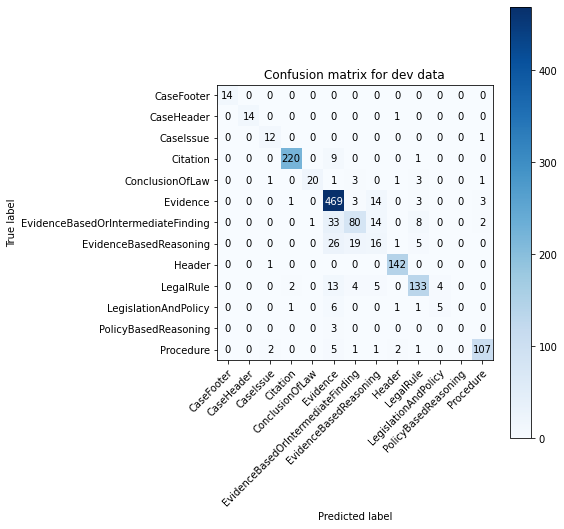

In [471]:
plot_confusion_matrix(dev_types, clf_TFIDF_linear.predict(X_dev_TFIDF), classes=list(clf_TFIDF_linear.classes_),
                      title='Confusion matrix for dev data')
plt.show()

### Observations
As a percentage of total instances in development set that are misclassified by the <i>Logistic Regression model with TFIDF Featurization </i> the worst performing types are:  
<ol> 
    <li> Policy Based Reasoning --> 100% misclassified </li>
    <li> Evidence Based Reasoning --> 76.2% misclassified </li>
    <li> Legislation and Policy --> 64.3% misclassified </li>
</ol>

### #2 Rbf SVM Kernel with Embedding Vectors

In [614]:
plot_confusion_matrix(dev_types, clf_default_Emb.predict(X_dev_Emb), classes=list(clf_Emb_RF_100.classes_),
                      title='Confusion matrix for dev data')
plt.show()

As s percentage of total instances in development set that are misclassified by the <i>Rbf SVM Kernel model with Embedding Vector Featurization</i> the worst performing types are:
<ol>
    <li> Policy Based Reasoning --> 100% misclassified</li>
    <li> Evidence Based Reasoning --> 77.6% misclassified</li>
    <li> Legislation and Policy --> 71.4% misclassified</li>

In [473]:
def make_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1), np.expand_dims(normalized_tokens_per_sentence_spans,axis=1)), axis=1)    
    return X, y

In [539]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [475]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations):
    span_data = []
    for a in annotations:
        start = a['start']
        end = a['end']
        document_txt = documents_by_id[a['document']]['plainText']
        atype = a['type']
        sd = {'txt': document_txt[start:end],
              'document': a['document'],
              'type': types_by_id[atype]['name'],
              'start': a['start'],
              'start_normalized': a['start'] / len(document_txt),
              # Results in a value between 0 and 1, which indicates where 
              # within the case text the sentence appears, i.e., a sentence
              # with 'start_normalized'=0.1 would be in the start, and one
              # with '0.9' will be near the end.
              'end': a['end']}
        span_data.append(sd)
    return span_data

In [504]:
spans = make_span_data(documents_by_id, types_by_id, annotations)

### Creating a Span list of dictionaries

In [511]:
def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [512]:
tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()

In [513]:
starts_normalized = np.array([s['start_normalized'] for s in spans])

In [516]:
spans_add_spacy_tokens(spans)

In [519]:
number_spans_sentence_tokens = 0
for span in spans:
    number_spans_sentence_tokens +=len(span['tokens_spacy'])
average_spans_sentence_tokens = number_spans_sentence_tokens/(float)(len(spans))

In [521]:
std_dev_spans = 0
number_tokens_per_span = list()
for span in spans:
    number_tokens_per_span.append(len(span['tokens_spacy']))
std_dev_spans = statistics.pstdev(number_tokens_per_span)

In [522]:
normalized_tokens_per_sentence_spans = list()
for span in spans:
    normalized_tokens_per_sentence_spans.append((len(span['tokens_spacy'])-average_spans_sentence_tokens)/std_dev_spans)

In [523]:
spans[0].keys()

dict_keys(['txt', 'document', 'type', 'start', 'start_normalized', 'end', 'tokens_spacy'])

In [524]:
len(normalized_tokens_per_sentence_spans)

15349

In [525]:
starts_normalized.shape

(15349,)

In [526]:
tfidf.shape

(15349, 3082)

In [527]:
X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1), np.expand_dims(normalized_tokens_per_sentence_spans,axis=1)), axis=1)    


In [528]:
X.shape

(15349, 3084)

In [531]:
# num_tokens = np.array([len(s['tokens_spacy']) for s in spans])


In [532]:
spans[0].keys()

dict_keys(['txt', 'document', 'type', 'start', 'start_normalized', 'end', 'tokens_spacy'])

In [533]:
# normalized_tokens_per_sentence_train = list()
# for i in range(len(train_sentences)):
#     doc = nlp(train_sentences[i])
#     normalized_tokens_per_sentence_train.append((len(list(doc))-average_sentence_length_train)/std_dev1)

In [534]:
len(spans[0]['tokens_spacy'])

63

In [535]:
spans[0].keys()

dict_keys(['txt', 'document', 'type', 'start', 'start_normalized', 'end', 'tokens_spacy'])

In [536]:
std_dev_spans

16.752081881845168

In [537]:
normalized_tokens_per_sentence_dev = list()
for i in range(len(dev_sentences)):
    doc = nlp(dev_sentences[i])
    normalized_tokens_per_sentence_dev.append((len(list(doc))-average_sentence_length_dev)/std_dev2)

## Phase 6 : Examining Misclassified Annotations

For the type "LegislationAndPolicy" we can see that the most of the annotations done by the annotator(s) is accurate, and the shortcoming is of the model in being unable to discern "LegislationAndPolicy" from "Header", "LegalRule", and other types.  
<p>
In one specific instance I believe the annotator has wrongly annotated a statement as "LegalRule":  
<em>The Veterans Claims Assistance Act of 2000 (VCAA), Pub. L.No. 106-475, 114 Stat. 2096 (Nov. 9, 2000) (codified at 
38 U.S.C.A. �� 5100, 5102, 5103, 5103A, 5106, 5107, and 5126 
(West 2002) redefined VA's duty to assist the veteran in the 
development of a claim.</em>   
The above statement, as per my opinion is correctly identified by my best performing model as a "LegislationAndPolicy" </p>
<p>Additionally there are cases where both the model and the annotator, in my opinion fail to annotate the statement correctly, for example the below statement is labelled as "Evidence": <br>
<em>VA has satisfied its duties under The Veteran's Claims Assistance Act of 2000 (VCAA) to notify and assist.
</em>
As per my understanding this statement should be classified as an "EvidenceBasedOrIntermediateFinding".</p>

In [616]:
prediction_errors(clf_TFIDF_linear,
                  random.sample(spans, 15349),
                  spacy_tfidf_vectorizer,
                  select_pred_label='PolicyBasedReasoning')

In [578]:
prediction_errors(clf_TFIDF_linear,
                  random.sample(spans, 15349),
                  spacy_tfidf_vectorizer,
                  select_pred_label= 'EvidenceBasedReasoning')

sentence # 220 / case 0920940.txt / @20927
pred: EvidenceBasedReasoning / true: PolicyBasedReasoning
 What 
has been consistently missing in this picture is Hickson 
element (3), medical evidence of a nexus between the claimed 
in-service disease or injury and the current disability.

sentence # 272 / case 1206738.txt / @11013
pred: EvidenceBasedReasoning / true: LegalRule
The Board is required to give consideration to all of the evidence received since the most recent denial of the claim in the March 1996 rating decision in light of the totality of the record.

sentence # 280 / case 1533186.txt / @13944
pred: EvidenceBasedReasoning / true: EvidenceBasedOrIntermediateFinding
The probativeness of the NAS Update 2012 regarding the Veteran's specific case appears to be limited.

sentence # 374 / case 0638940.txt / @12390
pred: EvidenceBasedReasoning / true: EvidenceBasedOrIntermediateFinding
While the record shows diagnoses of PTSD, such diagnoses are 
based entirely on the veteran's acco

In [617]:
prediction_errors(clf_TFIDF_linear,
                  random.sample(spans, 15349),
                  spacy_tfidf_vectorizer,
                  select_pred_label='LegislationAndPolicy')

sentence # 66 / case 1433336.txt / @1588
pred: LegislationAndPolicy / true: Header

FINDINGS OF FACT

sentence # 588 / case 0636017.txt / @2084
pred: LegislationAndPolicy / true: Header
I. Veterans Claims Assistance Act of 2000 (VCAA)

sentence # 608 / case 1550735.txt / @1102
pred: LegislationAndPolicy / true: Header
Veterans Claims Assistance Act (VCAA)

sentence # 1030 / case 1206738.txt / @1903
pred: LegislationAndPolicy / true: Header
The Veterans Claims Assistance Act of 2000 (VCAA)

sentence # 1429 / case 0740298.txt / @1559
pred: LegislationAndPolicy / true: LegalRule
The Veterans Claims Assistance Act of 2000 (VCAA), Pub. L. 
No. 106-475, 114 Stat. 2096 (Nov. 9, 2000) (codified at 
38 U.S.C.A. �� 5100, 5102, 5103, 5103A, 5106, 5107, and 5126 
(West 2002) redefined VA's duty to assist the veteran in the 
development of a claim.

sentence # 1644 / case 0610929.txt / @1806
pred: LegislationAndPolicy / true: Evidence
To implement the provisions of 
the law, the VA promulgated regu

In [615]:
prediction_errors(clf_TFIDF_linear,
                  random.sample(spans, 15349),
                  spacy_tfidf_vectorizer,
                  select_pred_label='Evidence')

sentence # 8 / case 1635641.txt / @14621
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
There was no reduction in muscle strength or muscle atrophy in the left hip. 

sentence # 14 / case 0639712.txt / @5120
pred: Evidence / true: Procedure
Any 
additional development efforts would serve no useful purpose. 

sentence # 31 / case 0610579.txt / @27422
pred: Evidence / true: LegalRule
Generally, the degrees of 
disability specified in the rating schedule are considered 
adequate to compensate for considerable loss of working time 
from exacerbations or illnesses proportionate to the severity 
of the several grades of disability.

sentence # 32 / case 0610579.txt / @19079
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
The Board, however, notes that the veteran primarily 
complains of pain and fatigue with repetitive motion 
resulting in decreased motion.

sentence # 38 / case 0830238.txt / @12860
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Although it ma

pred: Evidence / true: Procedure
The 
IME was also asked, in rendering her opinion, to reconcile 
the conflicting VA and private medical opinions described 
above.

sentence # 8277 / case 1622612.txt / @9809
pred: Evidence / true: Header
ORDER

sentence # 8296 / case 1218309.txt / @15974
pred: Evidence / true: EvidenceBasedReasoning
However, this does not significantly change the evidence that was already of record as the examiner reviewed records documenting a cardiac event in 1994, just three years later than the first cardiac event currently of record.

sentence # 8312 / case 0718642.txt / @10852
pred: Evidence / true: ConclusionOfLaw
The veteran may wish to contact the VA dental clinic for 
further information regarding outpatient dental treatment.

sentence # 8325 / case 1308350.txt / @22287
pred: Evidence / true: EvidenceBasedReasoning
However, the October 2012 letter the VA psychiatrist more generally indicates that the PTSD diagnosis is directly linked to the Veteran's reported

military service or other service-connected pathology.

sentence # 13796 / case 1312212.txt / @32172
pred: Evidence / true: Header
ORDER

sentence # 13811 / case 0721357.txt / @7328
pred: Evidence / true: EvidenceBasedReasoning
There is no indication that 
there exists any additional evidence that has a bearing on 
this case that has not been obtained. 

sentence # 13827 / case 1429023.txt / @13606
pred: Evidence / true: LegalRule
The most fundamental requirement for any claim for service connection is that the Veteran must have proof he has the condition claimed.

sentence # 13863 / case 1003865.txt / @12999
pred: Evidence / true: EvidenceBasedReasoning
However, in support of the claim is an 
April 2005 record from Dr. Benjamin Quinones that includes a 
diagnosis of minimal background diabetic retinopathy.

sentence # 13886 / case 1231338.txt / @30040
pred: Evidence / true: EvidenceBasedReasoning
The dated and current diagnoses set forth above further do not include a psychosis.

sent

In my observation the model mostly confuses "EvidenceBasedOrIntermediateFinding" for "EvidenceBasedReasoning" which is the case for manual annotators as well, thus demonstrating some understanding of the task, albeit not a complete understanding of the distinctions between the two types.

## Phase 8: Code Deliverable
Saving best model, which will then be callable from "analyze.py"

In [541]:
from joblib import dump, load
dump(clf_TFIDF_linear, 'best_model.joblib')

['best_model.joblib']

In [542]:
dump(clf_default_Emb, 'best2_model.joblib')

['best2_model.joblib']

In [543]:
predictions = clf_TFIDF_linear.predict(X_test_TFIDF)

In [544]:
len(predictions)

1524

In [548]:
#This works (below)
for i in range(len(predictions)):
    print(test_sentences[i],"-->",predictions[i],"\n")
    print("------------------------------------------------------")

____________________________________________
DEBORAH W. SINGLETON
Veterans Law Judge, Board of Veterans' Appeals




 --> CaseFooter 

------------------------------------------------------
 --> Header 

------------------------------------------------------
REPRESENTATION --> Header 

------------------------------------------------------
 --> Header 

------------------------------------------------------
INTRODUCTION --> Header 

------------------------------------------------------
 --> Header 

------------------------------------------------------

 --> Header 

------------------------------------------------------
 --> Header 

------------------------------------------------------

 --> Header 

------------------------------------------------------
Analysis --> Header 

------------------------------------------------------
Citation Nr: 0721357	
Decision Date: 07/17/07    Archive Date: 08/02/07

DOCKET NO.  05-13 724	)	DATE
	)
 --> CaseHeader 

------------------------------

------------------------------------------------------
See Gabrielson v. Brown, 7 Vet. App. 36, 39-40 (1994); Gilbert v. Derwinski, 1 Vet. App. 49, 57 (1990). --> Citation 

------------------------------------------------------
See Rucker v. Brown, 10 Vet. App. 67, 74 (1997); Layno v. Brown, 6 Vet. App. 465, 469 (1994); see also Cartwright v. Derwinski, 2 Vet. App. 24, 25 (1991) ("Although interest may affect the credibility of testimony, it does not affect competency to testify.") --> Citation 

------------------------------------------------------
Barr v. Nicholson, 21 Vet. App. 303, 309 (2007).  --> Citation 

------------------------------------------------------
 See Charles v. Principi, 16 Vet. App. 370 (2002).  --> Citation 

------------------------------------------------------
Charles v. Principi, 16 Vet. App. 370, 374 (2002) (finding veteran competent to testify to symptomatology capable of lay observation); Layno v. Brown, 6 Vet. App. 465, 469 (1994) (noting competent lay

veteran to stay with him. --> Evidence 

------------------------------------------------------
The soldier died while the veteran 
was with him. --> Evidence 

------------------------------------------------------
The psychologist concluded that the veteran 
was experiencing PTSD as a direct result of his participation 
in the Vietnam War. --> Evidence 

------------------------------------------------------
As noted above, the veteran maintains that while 
seeking treatment for his swollen left hand at Da Nang 
Hospital, he was told that his finger would be amputated. --> Evidence 

------------------------------------------------------
As he walked around the hospital, he 
saw many dead bodies and injured patients. --> Evidence 

------------------------------------------------------
In 
disagreement, the veteran was then advised to consult with 
the orthopedic surgeon. --> Evidence 

------------------------------------------------------
He eventually ran 
into a man who had a big

afforded medical examination. --> EvidenceBasedOrIntermediateFinding 

------------------------------------------------------
See Wells v. Principi, 326 
F.3d 1381 (Fed. Cir. 2003) (VA was not required to provide 
the veteran with a medical examination absent a showing by 
veteran of a causal connection between the disability and 
service). --> Evidence 

------------------------------------------------------
In this regard, there is no reasonable possibility 
that a VA examination would aid in substantiating the claim. --> Evidence 

------------------------------------------------------
38 U.S.C.A. � 5103A; 38 C.F.R. � 3.159. --> Citation 

------------------------------------------------------
Upon a review of the claims folder, the Board finds that the 
veteran and his representative were notified of the evidence 
and information necessary to substantiate his claim for 
service connection; were notified of the respective 
responsibilities of VA and himself as it pertained to who wa

He had been unable to squat or kneel for 30 years. --> Evidence 

------------------------------------------------------
The Veteran was diagnosed with degenerative arthritis, left knee, with significant varus deformity. --> Evidence 

------------------------------------------------------
The Veteran wrote in April 2003 that he could not bend the left knee all the way back when he entered service. --> Evidence 

------------------------------------------------------
Basic training put a lot of stress on the left leg and he was put in a special group because of not being able to keep up.  --> Evidence 

------------------------------------------------------
 --> Evidence 

------------------------------------------------------
A March 2008 letter from a VA treating doctor states that an x-ray showed an old fracture and some arthritis in the knee. --> Evidence 

------------------------------------------------------
The radiology report indicates a significant contour deformity of the d